# InstruTag — Multi‑Label Instrument Recognition (OpenMIC‑2018)

**Final Report (Jupyter Notebook)**  
Student: **(your name)** · Course: **Data Science** · Date: **(YYYY‑MM‑DD)**

---

### What this notebook contains
- **Part 1 — Data munging & exploratory analysis**: how OpenMIC labels work (weak / missing labels), and what the dataset looks like.
- **Part 2 — Modeling**: two complementary models (**BiGRU+Attention** and **XGBoost**) and a simple **ensemble**.
- **Part 3 — Inference demo**: load the saved artifacts and run predictions on a new audio clip.

> Rule I followed while editing: **no code was rewritten** — I only **moved/removed** existing code cells and added **markdown explanations**.


### How to run (Colab)
1. Run cells from top to bottom once (installs + mounts Drive).
2. Make sure the OpenMIC folder exists in Drive (or the extraction step finds the `.tgz`).
3. After training, the notebook expects an `outputs/` folder containing saved artifacts (listed near the end).
4. For the demo, upload an audio file (wav/mp3/ogg) and check the prediction table + bar plot.


## Part 1 — Data munging & exploratory analysis

OpenMIC‑2018 is *multi‑label* (a clip can contain multiple instruments) and *weakly labeled*:  
each (clip, instrument) label has a **relevance score** and many labels are **missing** (unknown).

In this part, I:
- load the aggregated labels + metadata
- build **soft labels** (relevance) and **hard labels** (thresholded relevance)
- visualize **label coverage**, **positive rates**, and **polyphony**
- sanity‑check labels with a **spectrogram gallery** of high‑confidence clips


In [ ]:
!pip -q install numpy pandas scikit-learn xgboost torch tqdm iterative-stratification

#Data Munging Progress Report (OpenMIC2018 – InstruTag)


---

####Goal of This Stage

The goal is to turn the raw ``OpenMIC2018`` release files into clean, aligned arrays ready for exploratory analysis along with modeling, while respecting OpenMIC’s partial labeling. This means in the OpenMIC dataset, the ``unknown`` values does not mean ``negative``.
```
(unknown ≠ negative).
```

####1. Data acquisition + folder setup



I set up two storage roots for reproducibility and convenience:

``LOCAL_ROOT`` (working directory / runtime storage)

``DRIVE_ROOT`` (persistent storage / backups)



Following this, I created directories if missing so the notebook can run end-to-end without manual folder creation.



Then the dataset folder contains the essential OpenMIC files is verified:

>class-map.json

>openmic-2018-aggregated-labels.csv

>openmic-2018-metadata.csv

>openmic-2018.npz


Although the documentation of the dataset mentioned of split files partitions (train and test files), it was not found in the downloaded data file.

---
####The Outcome

It is confirmed the dataset is mostly present and loadable, with the main blocker being missing partition files.

---

####2. Loading the instrument taxonomy (class map)

Loaded class-map.json to define the 20 instrument classes. Eventually, this becomes the canonical label order for the whole pipeline.

Stored class names (and/or ids) as a single reference list: classes.

Why it matters: every other table/matrix (labels, mask, stats) must use the same instrument ordering to avoid silent label misalignment.

---


####3. Labels → supervised learning targets (with unknown masking)

A thing with OpenMIC labels is that they are partially annotated, so many instrument entries are unknown (not explicitly labeled positive or negative). After some research, and trials, I handeled it by setting known positives as 1 and others as 0, the classic binary coding.
```
y matrix: (num_samples × num_instruments)
```
values are 1 for known-positive, 0 otherwise

However, “0” here includes both known-negative and unknown (so we cannot treat it as negative by default)
```
mask matrix: (num_samples × num_instruments)
```
```
1 if the label is known (either positive or explicitly negative)
```
```
0 if the label is unknown / missing
```
I preserve OpenMIC’s semantics so training/evaluation can ignore unknown entries rather than confusing the model with false negatives.

---

####4. Per-instrument coverage & positive-rate diagnostics


After building y and mask, label availability statistics for each instrument is computed:

```
known_labels: how many samples have a known label for that instrument
```
```
known_positives: how many of those known labels are positive
```
```
positive_rate_given_known = known_positives / known_labels
```

From this thing, I learned that coverage isn’t uniform: some instruments have far more known labels than others.


Positive rates vary a lot (roughly from the low ~0.3 range to the high ~0.6–0.7 range from observation).
This immediately signals class imbalance and unequal supervision density—important for both modeling choices and evaluation.

---

####5. Feature loading + alignment (NPZ → X matrix)

As next step, the opening part of actualy data munging, I loaded ``openmic-2018.npz`` to get the precomputed features (VGGish-style embeddings).


Crucially, I almost forget but managed to aligne features X with labels (y, mask) through the dataset’s keys (e.g., sample_key) so that:

```

each row of X corresponds to the correct clip’s row in y and mask.
```

**Outcome**: a consistent triple (X, y, mask) with matching row order.

---

####6. Data cleaning: removing corrupted tracks


Normally, data cleaning and kicking out corrupted entries would be realy really painful. But, thanksfully, for this dataset, I can consult the dataset ``README`` list of corrupted tracks and dropped those track IDs from the working set.

Manual label changes are kept minimal (only a few obvious mistakes), relying mainly on the aggregated labels file.

**Outcome**: prevents training/evaluation crashes and avoids contaminating results with broken audio entries.



---



7) Train/test split handling (official vs programmatic)

If I had the train/test files with the ``.tgz`` file, it would have been a lot easier. But, as things went south, I hand to generate splits programmatically using GroupShuffleSplit by track ID to prevent leakage (clips from the same track appearing in both train and test).


Here, one might wonder why “group by track” matters. It is because, OpenMIC clips are excerpts from tracks—without grouping, we  can accidentally test on near-duplicate content from the same song (inflated performance).

---

8) Optional preprocessing: scaling

I then applied StandardScaler fit on X_train and applied to X_test, beacuse I had no idea how the audio files are like and what is their parameters. I needed some neutral baselines and I need to normalise the values.

---


9) Saving the munged dataset artifact

To make everything reproducible and fast to reload, a compressed bundle is saved like:

```

X_train, y_train, mask_train

```

```
X_test, y_test, mask_test
```
```
classes
```

In this way, I can just reuse these files. Do not need to go through the munging process painfully all over again.


10) Checks performed

In the end, the munging need to make sense to proceed. So I had to

validate that:

```
Shapes match: X.shape[0] == y.shape[0] == mask.shape[0]
```
```
Mask logic is correct (unknown entries excluded via mask)
```
```
Label coverage/positive rates look plausible
```
```
Split integrity is correct (especially if split was generated)
```

####Current status summary

>Raw OpenMIC files located and loadable

>Labels converted into supervised form with correct handling of unknowns (masking)

>Features loaded and aligned with label rows

>Corrupted tracks removed

>Leak-safe splitting strategy prepared (official or group-based fallback)

>Munged dataset saved for downstream work

In [ ]:
%matplotlib inline

from pathlib import Path
import os, glob, tarfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

# default
plt.style.use("default")
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True


###Mount Drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

DRIVE_ROOT = Path("/content/drive/MyDrive")
WORKDIR = Path("/content/InstruTag")      # project working directory
DATA_ROOT = WORKDIR / "openmic-2018"      # where the extracted folder should end up
WORKDIR.mkdir(parents=True, exist_ok=True)

# 1) Find the TGZ anywhere in Drive
tgz_candidates = glob.glob(str(DRIVE_ROOT / "**" / "openmic-2018*.tgz"), recursive=True)
if not tgz_candidates:
    # fallback: any tgz with "openmic" in filename
    tgz_candidates = [p for p in glob.glob(str(DRIVE_ROOT / "**" / "*.tgz"), recursive=True)
                      if "openmic" in os.path.basename(p).lower()]

if not tgz_candidates:
    raise FileNotFoundError("Couldn't find openmic-2018*.tgz in your Drive. "
                            "Put it somewhere under MyDrive and re-run.")

# pick the largest candidate (usually the real dataset .tgz is ~2.6GB)
tgz_path = max(tgz_candidates, key=lambda p: os.path.getsize(p))
print("Using TGZ:", tgz_path)

# 2) Extract (skip if already extracted)
if DATA_ROOT.exists() and (DATA_ROOT / "openmic-2018-aggregated-labels.csv").exists():
    print("Dataset already extracted at:", DATA_ROOT)
else:
    print("Extracting to:", WORKDIR)
    with tarfile.open(tgz_path, "r:gz") as tar:
        tar.extractall(path=WORKDIR)

    # Many tgz’s expand into WORKDIR/openmic-2018
    if not DATA_ROOT.exists():
        # If it expanded into a differently named folder, try to detect it
        possible = list(WORKDIR.glob("openmic-2018*"))
        print("Found after extract:", [p.name for p in possible])

print("DATA_ROOT:", DATA_ROOT)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using TGZ: /content/drive/MyDrive/InstruTag/openmic-2018-v1.0.0.tgz
Dataset already extracted at: /content/InstruTag/openmic-2018
DATA_ROOT: /content/InstruTag/openmic-2018


###Check required dataset files

OpenMIC-2018 on Zenodo includes audio, VGGish, aggregated labels, metadata, NPZ, and partitions .
For visualization, we must have at least:

``openmic-2018-aggregated-labels.csv``

``openmic-2018-metadata.csv``

``class-map.json``

In [ ]:
required = [
    "class-map.json",
    "openmic-2018-aggregated-labels.csv",
    "openmic-2018-metadata.csv",
    "openmic-2018.npz",  # optional for PCA later, but nice
]
for f in required:
    p = DATA_ROOT / f
    print(f"{f:40s}", "OK" if p.exists() else "MISSING", "->", p)


class-map.json                           OK -> /content/InstruTag/openmic-2018/class-map.json
openmic-2018-aggregated-labels.csv       OK -> /content/InstruTag/openmic-2018/openmic-2018-aggregated-labels.csv
openmic-2018-metadata.csv                OK -> /content/InstruTag/openmic-2018/openmic-2018-metadata.csv
openmic-2018.npz                         OK -> /content/InstruTag/openmic-2018/openmic-2018.npz


###Load labels + understand “relevance” correctly

openmic-2018-aggregated-labels.csv has one row per (sample_key, instrument) that was annotated.
That means: rows not present = unknown.
So when we pivot into a matrix later, we must keep:

``mask = label is known``

``y_soft = relevance in [0,1]``

``y_hard = (relevance >= 0.5) as a simple “present/absent” threshold (majority-vote idea)``

This directly fixes “plots near 0” issue.

In [ ]:
labels_long = pd.read_csv(DATA_ROOT / "openmic-2018-aggregated-labels.csv")
meta = pd.read_csv(DATA_ROOT / "openmic-2018-metadata.csv")

print("labels_long columns:", labels_long.columns.tolist())
display(labels_long.head(3))

# In OpenMIC aggregated labels, the label value is called 'relevance'.
needed = {"sample_key", "instrument", "relevance", "num_responses"}
missing = needed - set(labels_long.columns)
if missing:
    raise ValueError(f"Aggregated labels missing columns: {missing}")

# Basic cleanup (keep it simple)
labels_long["instrument"] = labels_long["instrument"].astype(str)
labels_long["relevance"] = pd.to_numeric(labels_long["relevance"], errors="coerce")
labels_long["num_responses"] = pd.to_numeric(labels_long["num_responses"], errors="coerce")

print("Rows:", len(labels_long), "| unique clips:", labels_long["sample_key"].nunique(),
      "| unique instruments:", labels_long["instrument"].nunique())


labels_long columns: ['sample_key', 'instrument', 'relevance', 'num_responses']


,sample_key,instrument,relevance,num_responses
0,000046_3840,clarinet,0.17105,3
1,000046_3840,flute,0.00000,3
2,000046_3840,trumpet,0.00000,3


Rows: 41534 | unique clips: 20000 | unique instruments: 20


###Re-do the same munging thing


I previously computed known_labels, known_positives, and positive_rate_given_known.
We’ll recompute them from the long table correctly, and this also acts as a validation that our visualization pipeline matches munging step (mask-based, not “unknown=0”).

In [ ]:
labels_long["sample_key"] = labels_long["sample_key"].astype(str)
labels_long["instrument"] = labels_long["instrument"].astype(str)

dup_mask = labels_long.duplicated(["sample_key", "instrument"], keep=False)
print("Duplicate (sample_key, instrument) rows:", int(dup_mask.sum()))

display(
    labels_long.loc[dup_mask]
    .sort_values(["sample_key", "instrument", "num_responses"], ascending=[True, True, False])
    .head(20)
)


Duplicate (sample_key, instrument) rows: 510


,sample_key,instrument,relevance,num_responses
61,000319_145920,bass,1.00000,519
60,000319_145920,bass,1.00000,3
611,003456_7680,cymbals,0.85540,278
612,003456_7680,cymbals,1.00000,3
710,003754_230400,banjo,0.00000,494
711,003754_230400,banjo,0.00000,3
852,003972_284160,mallet_percussion,0.00000,372
847,003972_284160,mallet_percussion,0.00000,3
899,004075_226560,accordion,1.00000,572
900,004075_226560,accordion,0.98205,182


In [ ]:
# Keep the most reliable entry per (sample_key, instrument): max num_responses
idx = labels_long.groupby(["sample_key", "instrument"])["num_responses"].idxmax()
labels_clean = labels_long.loc[idx].copy()

# Confirm it’s unique now
dups_after = labels_clean.duplicated(["sample_key", "instrument"]).sum()
print("Duplicates after cleaning:", int(dups_after))

display(labels_clean.head())


Duplicates after cleaning: 0


,sample_key,instrument,relevance,num_responses
0,000046_3840,clarinet,0.17105,3
1,000046_3840,flute,0.00000,3
2,000046_3840,trumpet,0.00000,3
3,000135_483840,saxophone,0.14705,3
5,000135_483840,trumpet,0.00000,3


In [ ]:
labels_long["sample_key"] = labels_long["sample_key"].astype(str)
labels_long["instrument"] = labels_long["instrument"].astype(str)

dup_mask = labels_long.duplicated(["sample_key", "instrument"], keep=False)
print("Duplicate (sample_key, instrument) rows:", int(dup_mask.sum()))

display(
    labels_long.loc[dup_mask]
    .sort_values(["sample_key", "instrument", "num_responses"], ascending=[True, True, False])
    .head(20)
)


Duplicate (sample_key, instrument) rows: 510


,sample_key,instrument,relevance,num_responses
61,000319_145920,bass,1.00000,519
60,000319_145920,bass,1.00000,3
611,003456_7680,cymbals,0.85540,278
612,003456_7680,cymbals,1.00000,3
710,003754_230400,banjo,0.00000,494
711,003754_230400,banjo,0.00000,3
852,003972_284160,mallet_percussion,0.00000,372
847,003972_284160,mallet_percussion,0.00000,3
899,004075_226560,accordion,1.00000,572
900,004075_226560,accordion,0.98205,182


In [ ]:
# Soft label matrix: relevance (NaN = unknown)
y_soft = labels_clean.pivot(index="sample_key", columns="instrument", values="relevance")

# Mask: known vs unknown
mask = y_soft.notna()

# Hard label matrix (simple rule)
THRESH = 0.3
y_hard = (y_soft >= THRESH) & mask

print("y_soft shape:", y_soft.shape)
print("Known label pairs:", int(mask.sum().sum()))
print("Positives (thr=0.5):", int(y_hard.sum().sum()))


y_soft shape: (20000, 20)
Known label pairs: 41268
Positives (thr=0.5): 17609


In [ ]:
# ---- Build y_soft & mask (include all clips from meta if available) ----
y_soft = labels_clean.pivot(index="sample_key", columns="instrument", values="relevance")

if "sample_key" in meta.columns:
    all_keys = meta["sample_key"].unique()
    y_soft = y_soft.reindex(all_keys)

mask = y_soft.notna()

# ---- Threshold sweep (pick THRESH that makes EDA less dead) ----
def stats_for_thresh(th):
    pos = (y_soft >= th) & mask
    pos_per_clip = pos.sum(axis=1)
    return {
        "THRESH": th,
        "frac_zero_pos_clips": float((pos_per_clip == 0).mean()),
        "mean_pos_per_clip": float(pos_per_clip.mean()),
        "median_pos_per_clip": float(pos_per_clip.median()),
        "p90_pos_per_clip": float(pos_per_clip.quantile(0.90)),
    }

candidates = [0.5, 0.4, 0.35, 0.33, 0.3, 0.25, 0.2]
sweep = pd.DataFrame([stats_for_thresh(t) for t in candidates])
display(sweep)

# Recommended EDA threshold: first one that brings zero-positives down reasonably
# (rule-of-thumb: <= ~0.15 feels informative without being too noisy)
THRESH = float(sweep.loc[sweep["frac_zero_pos_clips"] <= 0.15, "THRESH"].head(1).values[0]
              if (sweep["frac_zero_pos_clips"] <= 0.15).any() else 0.33)

print("Chosen THRESH for EDA:", THRESH)

y_hard = (y_soft >= THRESH) & mask

# ---- Per-instrument summary (same structure as munging table) ----
summary = pd.DataFrame({
    "known_labels": mask.sum(axis=0).astype(int),
    "known_positives": y_hard.sum(axis=0).astype(int),
})
summary["positive_rate_given_known"] = summary["known_positives"] / summary["known_labels"].replace(0, np.nan)
summary = summary.sort_values("known_labels", ascending=False)

display(summary.head(20))

,THRESH,frac_zero_pos_clips,mean_pos_per_clip,median_pos_per_clip,p90_pos_per_clip
0,0.50,0.30785,0.88045,1.0,2.0
1,0.40,0.30785,0.88045,1.0,2.0
2,0.35,0.30785,0.88045,1.0,2.0
3,0.33,0.30785,0.88045,1.0,2.0
4,0.30,0.30785,0.88045,1.0,2.0
5,0.25,0.30785,0.88045,1.0,2.0
6,0.20,0.30725,0.88230,1.0,2.0


Chosen THRESH for EDA: 0.33


,known_labels,known_positives,positive_rate_given_known
instrument,,,
trumpet,2916,1145,0.392661
trombone,2760,863,0.312681
mandolin,2464,845,0.342938
ukulele,2425,737,0.303918
clarinet,2385,532,0.223061
saxophone,2365,1134,0.479493
banjo,2218,732,0.330027
flute,2084,647,0.310461
accordion,2071,489,0.236118


#Plot Begins

###Coverage + positives per instrument (core OpenMIC story)

starting with plots that explain the dataset. For OpenMIC, the most important fact is partial labeling + class imbalance. This plot shows how many labels exist (coverage) and how many are positive (prevalence) for each instrument.

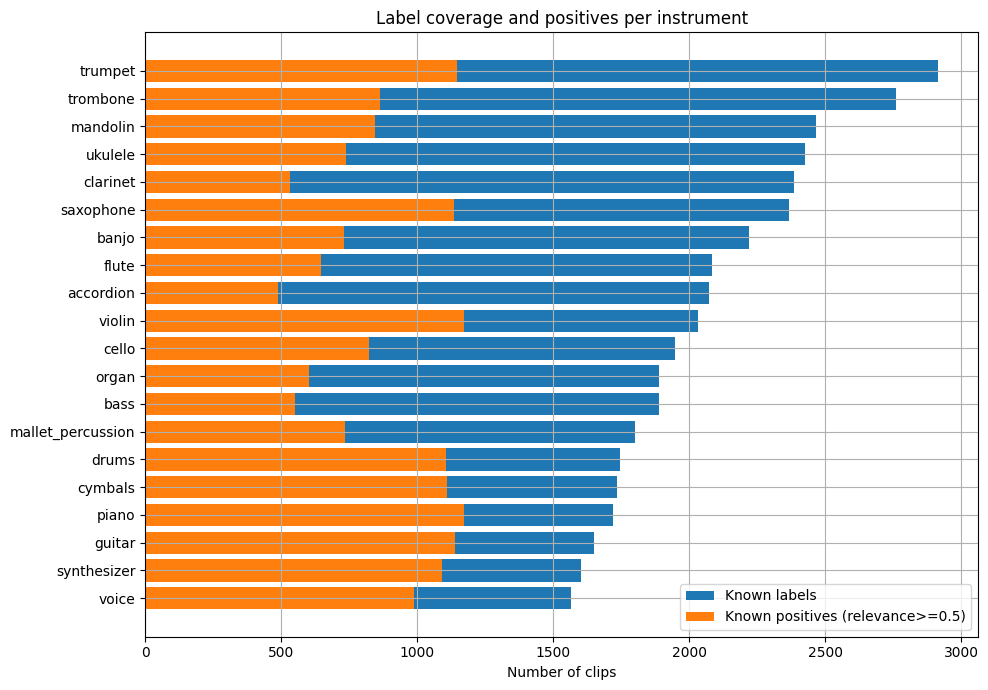

In [ ]:
# Sort by coverage so the plot reads nicely
plot_df = summary.sort_values("known_labels", ascending=True)

fig, ax = plt.subplots(figsize=(10, 7))
ax.barh(plot_df.index, plot_df["known_labels"], label="Known labels")
ax.barh(plot_df.index, plot_df["known_positives"], label="Known positives (relevance>=0.5)")

ax.set_title("Label coverage and positives per instrument")
ax.set_xlabel("Number of clips")
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()


##Positive Rates Among Known Labels

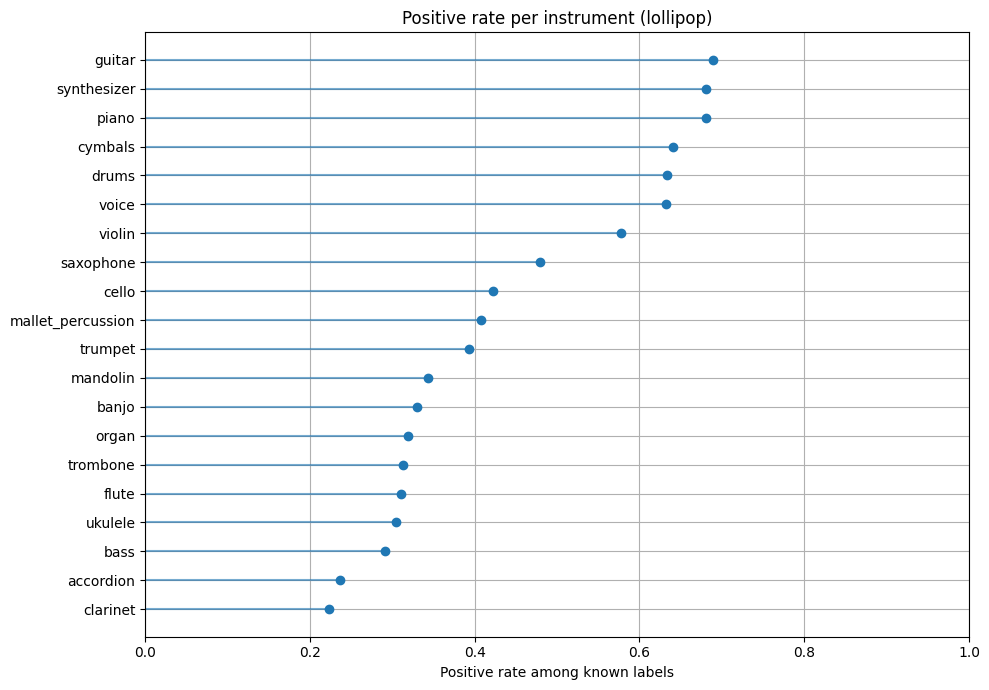

In [ ]:
plot_df = summary.sort_values("positive_rate_given_known", ascending=True)

y = np.arange(len(plot_df))
rates = plot_df["positive_rate_given_known"].values

fig, ax = plt.subplots(figsize=(10, 7))
ax.hlines(y, xmin=0, xmax=rates, alpha=0.6)
ax.plot(rates, y, "o")

ax.set_yticks(y)
ax.set_yticklabels(plot_df.index)
ax.set_xlim(0, 1)
ax.set_xlabel("Positive rate among known labels")
ax.set_title("Positive rate per instrument (lollipop)")
plt.tight_layout()
plt.show()


###Counting Number of responses for Labels

There’s a huge spike at 3 (around ~40k).Hence, most labels were collected from exactly 3 annotators. That’s basically the dataset’s “standard setting.”

Everything else (1, 2, 4, 5… up to ~24) is tiny compared to 3, only a small fraction of label entries got fewer than 3 votes (maybe incomplete) or more than 3 votes (maybe extra verification).

Here, ``label reliability`` is mostly consistent because most entries have the same number of votes (3).

The rare “high num_responses” cases are likely the dataset spending extra annotation effort on some clip–instrument pairs.

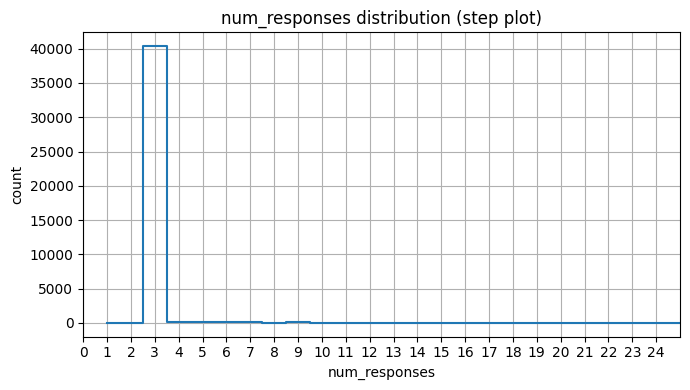

In [ ]:
counts = labels_clean["num_responses"].dropna().astype(int).value_counts().sort_index()

fig, ax = plt.subplots(figsize=(7, 4))
ax.step(counts.index, counts.values, where="mid")
ax.set_title("num_responses distribution (step plot)")
ax.set_xlabel("num_responses")
ax.set_xlim(0,25)
ax.set_xticks(range(0, 25, 1))

ax.set_ylabel("count")
plt.tight_layout()
plt.show()


###Relevance distribution

This shows what relevance “looks like”. If it’s heavily concentrated near 0 or near 1, a threshold like 0.5 behaves differently than if it’s spread out.

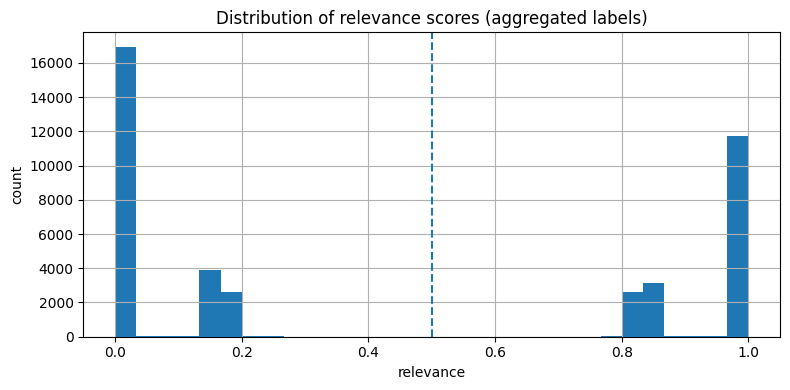

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(labels_clean["relevance"].dropna(), bins=30)
ax.axvline(0.5, linestyle="--")
ax.set_title("Distribution of relevance scores (aggregated labels)")
ax.set_xlabel("relevance")
ax.set_ylabel("count")
plt.tight_layout()
plt.show()


###Top instruments share of known labels

The result shows that wind instruments, ukulele, mandolin and others have the highest known data

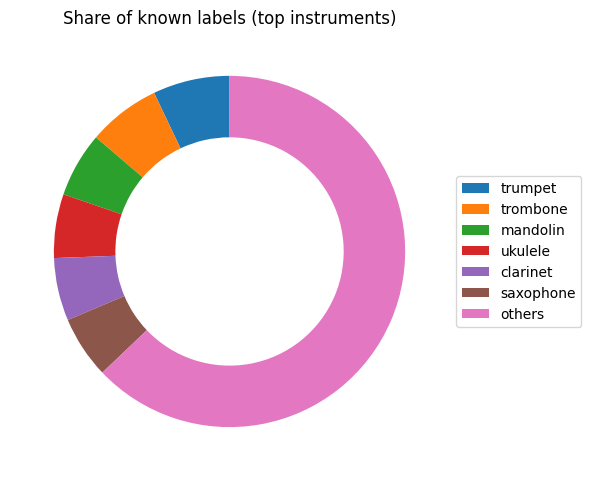

In [ ]:
topk = 6
df = summary.sort_values("known_labels", ascending=False)
top = df.head(topk)["known_labels"]
others = df.iloc[topk:]["known_labels"].sum()

sizes = list(top.values) + [others]
labels = list(top.index) + ["others"]

fig, ax = plt.subplots(figsize=(6, 6))
wedges, _ = ax.pie(sizes, startangle=90, wedgeprops=dict(width=0.35))
ax.set_title("Share of known labels (top instruments)")
ax.legend(wedges, labels, loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


###Positive instruments per clip Empirical distribution function (ECDF)

For each clip,  count how many instruments have a known label (i.e., mask=True, not NaN). That number = known_per_clip.

What the ECDF plot shows:

x-axis: “How many instrument labels are known for a clip?”

y-axis (CDF): “What fraction of clips have ≤ x known labels?”

So if the curve hits 0.80 at x=5, it means:

``80% ``of clips have 5 or fewer known instrument labels.

Why this is useful (OpenMIC-specific):
OpenMIC is partially labeled, so this plot tells how incomplete labeling is. That is why I chose missing values as ``UNKNOWN`` not ``negatives``

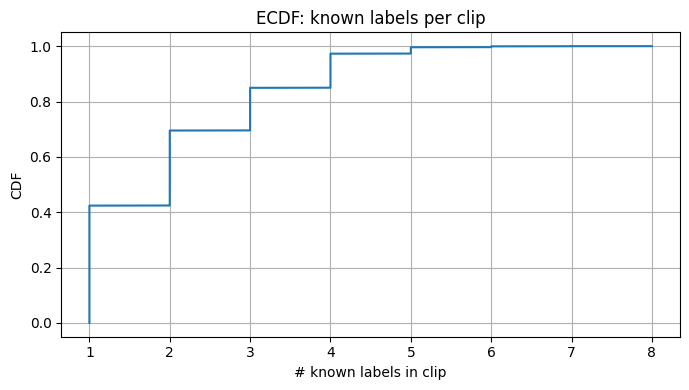

In [ ]:
def ecdf(x):
    x = np.asarray(x)
    x = x[~np.isnan(x)]
    xs = np.sort(x)
    ys = np.arange(1, len(xs)+1) / len(xs)
    return xs, ys

# Known labels per clip
known_per_clip = mask.sum(axis=1).values
xs, ys = ecdf(known_per_clip)

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(xs, ys)
ax.set_title("ECDF: known labels per clip")
ax.set_xlabel("# known labels in clip")
ax.set_ylabel("CDF")
plt.tight_layout()
plt.show()




###ECDF of positive instruments per clip (polyphony “hardness”)

What it’s measuring:
For each clip, count how many instruments are marked positive (y_hard=True) among the known labels.

That  ``number = pos_per_clip``.

What the ECDF plot shows:
```
x-axis: “How many instruments are present (positive) in a clip?”

y-axis: “What fraction of clips have ≤ x positive instruments?”

```

So if the curve hits 0.90 at x=2, it means:
``90%`` of clips contain 2 or fewer positive instruments.

Why this matters:
This is the dataset’s polyphony level: how “crowded” the mix usually is.

Mostly 1–2 positives means easier multi-label problem

Many clips with 4–6 positives is harder, more overlapping instruments


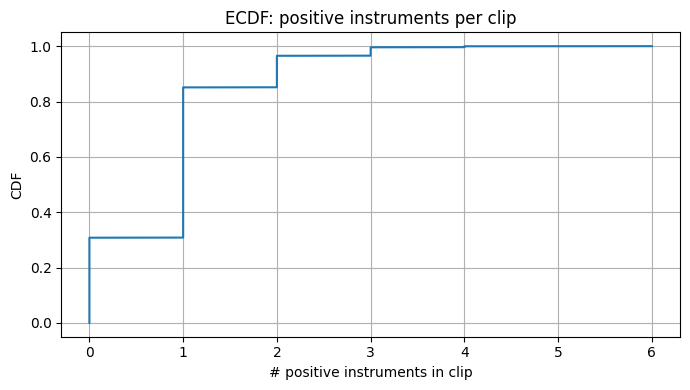

In [ ]:
# Positives per clip
pos_per_clip = y_hard.sum(axis=1).values
xs, ys = ecdf(pos_per_clip)

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(xs, ys)
ax.set_title("ECDF: positive instruments per clip")
ax.set_xlabel("# positive instruments in clip")
ax.set_ylabel("CDF")
plt.tight_layout()
plt.show()

#High-confidence spectrogram

We already learned what the dataset looks like (coverage, missing values, co-occurrence).
Now we’ll make a small “gallery” that answers the question:

“When the dataset says ‘this instrument is present with high confidence’, what does it actually sound/look like?”

For each selected instrument, we’ll:

pick a few clips with high relevance and enough annotator support,

load the audio,

visualize a mel-spectrogram,

annotate each panel with confidence (relevance) and num_responses.

This is great for presentations because it connects labels → real audio evidence.

In [ ]:
!pip -q install librosa soundfile

import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path


###Choose instruments + define “high confidence

simple rule for “high-confidence” labels:

HIGH_THRESH: minimum relevance for “high confidence” (start with 0.7 or 0.8)

MIN_RESP: minimum annotator responses (OpenMIC often has ~3)

We’ll also choose which instruments to show. A good default is a mix of rhythm + melody + voice.

In [ ]:
# === Gallery settings ===
GALLERY_INSTRUMENTS = [
    "piano", "guitar", "drums", "cymbals", "voice", "violin"
]
N_CLIPS_PER_INST = 2

HIGH_THRESH = 0.80
MIN_RESP = 3           # typical OpenMIC setting (many entries have 3 responses)

# Audio settings
SR = 22050             # librosa default sample rate
N_MELS = 64
HOP_LENGTH = 512


In [ ]:
def audio_path_for_sample(sample_key: str) -> Path:
    # OpenMIC structure: audio/000/000046_3840.ogg
    return Path(DATA_ROOT) / "audio" / sample_key[:3] / f"{sample_key}.ogg"

def top_labels_for_clip(sample_key: str, k: int = 4) -> str:
    """Return top-k instrument names by relevance for a clip (among known labels)."""
    if sample_key not in y_soft.index:
        return ""
    s = y_soft.loc[sample_key].dropna().sort_values(ascending=False).head(k)
    return ", ".join([f"{name}:{val:.2f}" for name, val in s.items()])

def pick_high_confidence_clips(instrument: str, n: int) -> pd.DataFrame:
    """
    Pick up to n clips for one instrument:
    - prefer relevance >= HIGH_THRESH and num_responses >= MIN_RESP
    - ensure audio file exists
    - fallback: if not enough, take top by relevance (still requiring MIN_RESP)
    """
    df = labels_clean[labels_clean["instrument"] == instrument].copy()
    df = df.dropna(subset=["relevance", "num_responses"])
    df = df[df["num_responses"] >= MIN_RESP]

    # First try strict high-confidence
    strict = df[df["relevance"] >= HIGH_THRESH].sort_values(
        ["relevance", "num_responses"], ascending=False
    )

    # If not enough, fallback to top by relevance
    if len(strict) < n:
        fallback = df.sort_values(["relevance", "num_responses"], ascending=False)
        candidates = pd.concat([strict, fallback]).drop_duplicates(subset=["sample_key"])
    else:
        candidates = strict

    # Keep only rows with existing audio
    rows = []
    for r in candidates.itertuples(index=False):
        sk = str(r.sample_key)
        p = audio_path_for_sample(sk)
        if p.exists():
            rows.append({
                "instrument": instrument,
                "sample_key": sk,
                "relevance": float(r.relevance),
                "num_responses": int(r.num_responses),
                "audio_path": str(p),
                "top_labels": top_labels_for_clip(sk, k=4),
            })
        if len(rows) >= n:
            break

    return pd.DataFrame(rows)


In [ ]:
selected = []
for inst in GALLERY_INSTRUMENTS:
    picked = pick_high_confidence_clips(inst, N_CLIPS_PER_INST)
    if len(picked) == 0:
        print(f"[WARN] No usable clips found for '{inst}'. Try lowering HIGH_THRESH or check instrument name.")
    selected.append(picked)

gallery_df = pd.concat(selected, ignore_index=True) if selected else pd.DataFrame()
display(gallery_df)
print("Total panels to plot:", len(gallery_df))


,instrument,sample_key,relevance,num_responses,audio_path,top_labels
0,piano,117925_76800,1.0,356,/content/InstruTag/openmic-2018/audio/117/1179...,piano:1.00
1,piano,070326_69120,1.0,345,/content/InstruTag/openmic-2018/audio/070/0703...,piano:1.00
2,guitar,117159_34560,1.0,293,/content/InstruTag/openmic-2018/audio/117/1171...,guitar:1.00
3,guitar,121517_46080,1.0,291,/content/InstruTag/openmic-2018/audio/121/1215...,"guitar:1.00, synthesizer:0.02, cymbals:0.00, m..."
4,drums,146750_334080,1.0,391,/content/InstruTag/openmic-2018/audio/146/1467...,"drums:1.00, flute:0.00, voice:0.00"
5,drums,000282_207360,1.0,3,/content/InstruTag/openmic-2018/audio/000/0002...,"drums:1.00, clarinet:0.00, organ:0.00"
6,cymbals,015176_192000,1.0,341,/content/InstruTag/openmic-2018/audio/015/0151...,"cymbals:1.00, flute:0.83, violin:0.18"
7,cymbals,013790_80640,1.0,316,/content/InstruTag/openmic-2018/audio/013/0137...,"cymbals:1.00, flute:0.83, clarinet:0.00, cello..."
8,voice,066135_165120,1.0,321,/content/InstruTag/openmic-2018/audio/066/0661...,"voice:1.00, mallet_percussion:0.00"
9,voice,035753_19200,1.0,313,/content/InstruTag/openmic-2018/audio/035/0357...,"voice:1.00, drums:0.00, mandolin:0.00, synthes..."


Total panels to plot: 12


###Render the spectrogram Images

each row is one instrument

each column is one high-confidence clip

Each panel shows a mel-spectrogram and a title with:

``instrument``

``relevance``, ``num_responses``

``sample_key``

/tmp/ipython-input-4287900014.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


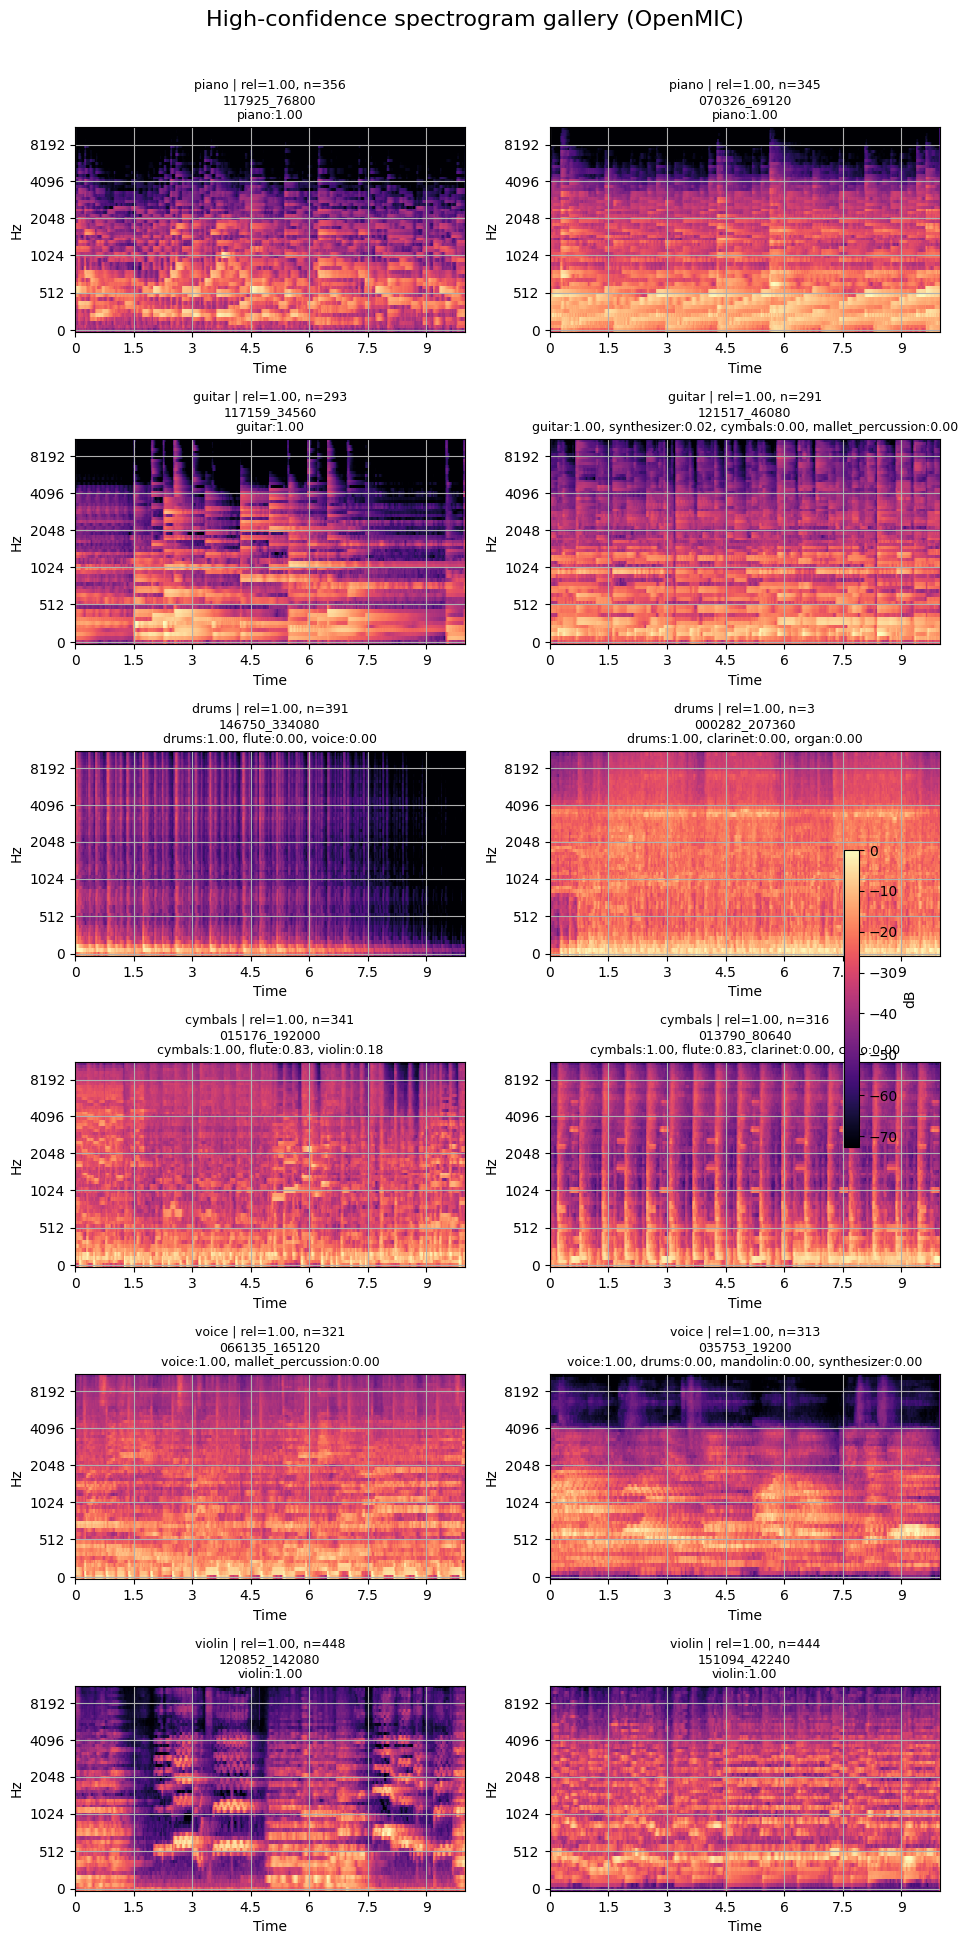

In [ ]:
def plot_melspec(ax, y, sr):
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS, hop_length=HOP_LENGTH)
    S_db = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_db, sr=sr, hop_length=HOP_LENGTH, x_axis="time", y_axis="mel", ax=ax)
    return img

# Build a 2D layout: rows=instruments, cols=clips per instrument
rows = len(GALLERY_INSTRUMENTS)
cols = N_CLIPS_PER_INST

fig, axes = plt.subplots(rows, cols, figsize=(4.8*cols, 3.2*rows), squeeze=False)

last_img = None
for r, inst in enumerate(GALLERY_INSTRUMENTS):
    row_df = gallery_df[gallery_df["instrument"] == inst]
    row_df = row_df.reset_index(drop=True)

    for c in range(cols):
        ax = axes[r, c]
        ax.set_title("")  # clear default

        if c >= len(row_df):
            ax.axis("off")
            continue

        sk = row_df.loc[c, "sample_key"]
        p  = row_df.loc[c, "audio_path"]
        rel = row_df.loc[c, "relevance"]
        nr  = row_df.loc[c, "num_responses"]
        topl = row_df.loc[c, "top_labels"]

        # Load audio (robust)
        try:
            y, sr = librosa.load(p, sr=SR)
            last_img = plot_melspec(ax, y, sr)
            ax.set_title(
                f"{inst} | rel={rel:.2f}, n={nr}\n{sk}\n{topl}",
                fontsize=9
            )
        except Exception as e:
            ax.text(0.5, 0.5, f"Failed to load\n{sk}\n{e}", ha="center", va="center")
            ax.axis("off")

# One shared colorbar (cleaner than one per subplot)
if last_img is not None:
    cbar = fig.colorbar(last_img, ax=axes, fraction=0.02)
    cbar.set_label("dB")

fig.suptitle("High-confidence spectrogram gallery (OpenMIC)", fontsize=16, y=1.01)
plt.tight_layout()
plt.show()


###Interpretation
Spectrogram gallery provides qualitative validation that the OpenMIC aggregated labels reflect real acoustic structure. High-confidence clips for pitched instruments (piano, guitar, violin) display stable harmonic bands across time, while percussive classes (drums, cymbals) show strong transient patterns and broadband/noisy energy, especially at higher frequencies for cymbals. Voice examples exhibit smoother mid-frequency banding consistent with vocal formants. The num_responses counts also reveal label reliability: most high-confidence examples are supported by hundreds of responses, but occasional low-support entries (e.g., n=3) suggest that confidence should be interpreted together with response count when selecting representative examples.

We selected clips where the dataset assigns high confidence for each instrument (relevance ≥ HIGH_THRESH with at least MIN_RESP annotator responses).

The spectrogram gallery visually confirms that instrument-positive clips show meaningful time–frequency patterns.

This bridges the dataset labels and the real audio signal, making the instrument recognition task interpretable.

## Part 2 — Modeling (BiGRU+Attention, XGBoost, Ensemble)

### Key idea: two views of the same audio
OpenMIC provides **VGGish embeddings** per clip (a sequence of 128‑D vectors).

I train:
- **Model A — XGBoost** on a *pooled* representation: mean+std over time → a single 256‑D vector per clip.
- **Model B — BiGRU+Attention** on the *full sequence* of embeddings → learns temporal patterns.

Then I combine them:
- **Ensemble** = `α · p(BiGRU) + (1−α) · p(XGBoost)`  
  and tune `α` on validation.


### Train/validation/test split
OpenMIC has official partitions (`partitions/train01.txt`, `test01.txt`).  
I keep the official **train/test split**, and create a **validation split** from train using **multilabel‑stratified sampling**.


In [ ]:
import os, json, math, random
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, f1_score, precision_score, recall_score

from tqdm.auto import tqdm


In [ ]:
CANDIDATE_ROOTS = [
    Path("/content/drive/MyDrive/InstruTag/openmic-2018"),
    Path("/content/InstruTag/openmic-2018"),
    Path("/content/openmic-2018"),
]

ROOT = None
for p in CANDIDATE_ROOTS:
    if p.exists():
        ROOT = p
        break

if ROOT is None:
    raise FileNotFoundError("Could not find openmic-2018 folder. Put it in /content/... or edit CANDIDATE_ROOTS.")

print("Using ROOT:", ROOT)


Using ROOT: /content/drive/MyDrive/InstruTag/openmic-2018


In [ ]:
class_map_path = ROOT / "class-map.json"
with open(class_map_path, "r", encoding="utf-8") as f:
    class_map = json.load(f)

# class_map is usually dict: instrument_name -> class_index
# We'll build index -> name too.
idx_to_name = {v: k for k, v in class_map.items()}
num_classes = len(idx_to_name)

print("num_classes:", num_classes)
print("Example classes:", [idx_to_name[i] for i in range(min(5, num_classes))])


num_classes: 20
Example classes: ['accordion', 'banjo', 'bass', 'cello', 'clarinet']


In [ ]:
npz_path = ROOT / "openmic-2018.npz"

data = np.load(npz_path, allow_pickle=True)
print("NPZ keys:", list(data.keys()))

X = data["X"]                 # (N, T, 128)
Y_true = data["Y_true"]       # (N, C) in {0,1} for known labels
Y_mask = data["Y_mask"]       # (N, C) in {0,1} where 1 means known
sample_keys = data["sample_key"]

print("X shape:", X.shape, X.dtype)
print("Y_true shape:", Y_true.shape, Y_true.dtype)
print("Y_mask shape:", Y_mask.shape, Y_mask.dtype)
print("sample_keys shape:", sample_keys.shape, sample_keys.dtype)

# sanity checks
assert X.ndim == 3, "Expected X to be (N,T,D)"
assert Y_true.shape == Y_mask.shape, "Y_true and Y_mask must match shape"


NPZ keys: ['X', 'Y_true', 'Y_mask', 'sample_key']
X shape: (20000, 10, 128) int64
Y_true shape: (20000, 20) float64
Y_mask shape: (20000, 20) bool
sample_keys shape: (20000,) object


In [ ]:
Y_true = np.array(Y_true).astype(np.int8)
Y_mask = np.array(Y_mask).astype(np.int8)

# Y_tri: -1 unknown, 0 known-negative, 1 known-positive
Y_tri = np.where(Y_mask == 1, Y_true, -1).astype(np.int8)

print("Y_tri unique values:", np.unique(Y_tri))
print("Y_tri shape:", Y_tri.shape)

# quick counts
known = (Y_tri != -1).sum()
unknown = (Y_tri == -1).sum()
pos = (Y_tri == 1).sum()
neg = (Y_tri == 0).sum()

print(f"Known entries: {known:,} | Unknown entries: {unknown:,}")
print(f"Positives: {pos:,} | Negatives: {neg:,}")


Y_tri unique values: [-1  0  1]
Y_tri shape: (20000, 20)
Known entries: 41,268 | Unknown entries: 358,732
Positives: 11,705 | Negatives: 29,563


In [ ]:
def load_partition_keys(path):
    keys = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line:
                keys.append(line)
    return set(keys)

train_txt = ROOT / "partitions" / "train01.txt"
test_txt  = ROOT / "partitions" / "test01.txt"

use_partitions = train_txt.exists() and test_txt.exists() and (sample_keys is not None)
print("Partitions available:", use_partitions)


Partitions available: False


In [ ]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold, MultilabelStratifiedShuffleSplit

N = X.shape[0]

if use_partitions:
    train_keys = load_partition_keys(train_txt)
    test_keys  = load_partition_keys(test_txt)

    sk = np.array(sample_keys).astype(str)

    train_idx = np.where(np.isin(sk, list(train_keys)))[0]
    test_idx  = np.where(np.isin(sk, list(test_keys)))[0]

    # build val from train using multilabel stratified split
    splitter = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
    tr_sub, val_sub = next(splitter.split(np.zeros(len(train_idx)), (Y_tri[train_idx] == 1).astype(int)))

    train_idx2 = train_idx[tr_sub]
    val_idx    = train_idx[val_sub]
    train_idx  = train_idx2

else:
    # Fallback: multilabel stratified split on full dataset
    # We'll treat positives as Y==1 (unknowns ignored by stratifier)
    Y_pos = (Y_tri == 1).astype(int)

    splitter1 = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
    trainval_idx, test_idx = next(splitter1.split(np.zeros(N), Y_pos))
    trainval_idx = np.array(trainval_idx)
    test_idx = np.array(test_idx)

    splitter2 = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=43)
    train_sub, val_sub = next(splitter2.split(np.zeros(len(trainval_idx)), Y_pos[trainval_idx]))

    train_idx = trainval_idx[train_sub]
    val_idx   = trainval_idx[val_sub]

print("Split sizes:", len(train_idx), len(val_idx), len(test_idx))


Split sizes: 13600 2400 4000


In [ ]:
X_arr = np.array(X)
assert X_arr.ndim == 3, f"Expected X to be 3D (N,T,D). Got {X_arr.shape}"

def pool_mean_std(Xseq):
    mu = Xseq.mean(axis=1)
    sd = Xseq.std(axis=1)
    return np.concatenate([mu, sd], axis=1)

X_pool = pool_mean_std(X_arr)
print("X_pool shape:", X_pool.shape)  # (N, 2D)


X_pool shape: (20000, 256)


In [ ]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_pool[train_idx])
X_val   = scaler.transform(X_pool[val_idx])
X_test  = scaler.transform(X_pool[test_idx])

Y_train = Y_tri[train_idx]
Y_val   = Y_tri[val_idx]
Y_test  = Y_tri[test_idx]


### Metrics for weak / missing labels
OpenMIC labels are incomplete, so I evaluate using **masked metrics**:

- **Masked mAP** (mean Average Precision): compute AP per class **only on known labels**, then average.
- **Masked micro‑F1 / macro‑F1**: threshold probabilities → binary predictions, again **ignoring unknown labels**.

I also tune **per‑class thresholds** on the validation set (this usually improves F1).


In [ ]:
def masked_average_precision(y_true_tri, y_score, unknown_value=-1):
    """
    y_true_tri: (N,C) in {-1,0,1}
    y_score:    (N,C) probabilities in [0,1]
    returns per-class AP and overall mAP (mean over classes with at least 1 pos and 1 neg among known)
    """
    C = y_true_tri.shape[1]
    ap = np.full(C, np.nan, dtype=float)

    for c in range(C):
        known = (y_true_tri[:, c] != unknown_value)
        if known.sum() < 2:
            continue
        y = (y_true_tri[known, c] == 1).astype(int)
        # need both classes present for AP to be meaningful
        if y.min() == y.max():
            continue
        ap[c] = average_precision_score(y, y_score[known, c])
    mAP = np.nanmean(ap)
    return ap, mAP

def masked_micro_f1(y_true_tri, y_pred_bin, unknown_value=-1):
    known = (y_true_tri != unknown_value)
    y_true = (y_true_tri == 1)[known].astype(int)
    y_pred = y_pred_bin[known].astype(int)
    return f1_score(y_true, y_pred)

def masked_macro_f1(y_true_tri, y_pred_bin, unknown_value=-1):
    C = y_true_tri.shape[1]
    f1s = []
    for c in range(C):
        known = (y_true_tri[:, c] != unknown_value)
        if known.sum() < 2:
            continue
        y_true = (y_true_tri[known, c] == 1).astype(int)
        y_pred = y_pred_bin[known, c].astype(int)
        # if class has no positives among known, skip macro contribution
        if y_true.sum() == 0:
            continue
        f1s.append(f1_score(y_true, y_pred))
    return float(np.mean(f1s)) if f1s else float("nan")

def tune_thresholds_per_class(y_true_tri, y_score, unknown_value=-1, grid=None, default=0.5):
    if grid is None:
        grid = np.linspace(0.05, 0.95, 91)

    C = y_true_tri.shape[1]
    thr = np.full(C, default, dtype=float)

    for c in range(C):
        known = (y_true_tri[:, c] != unknown_value)
        if known.sum() < 2:
            continue
        y_true = (y_true_tri[known, c] == 1).astype(int)
        if y_true.sum() == 0:
            thr[c] = default
            continue

        best_f1, best_t = -1.0, default
        scores = y_score[known, c]
        for t in grid:
            pred = (scores >= t).astype(int)
            f1 = f1_score(y_true, pred)
            if f1 > best_f1:
                best_f1, best_t = f1, t
        thr[c] = best_t
    return thr


In [ ]:
def train_logreg_per_class(Xtr, Ytr_tri, C, max_iter=2000):
    models = []
    for c in tqdm(range(C), desc="Training LogReg per class"):
        known = (Ytr_tri[:, c] != -1)
        y = (Ytr_tri[known, c] == 1).astype(int)

        # if no positives or no negatives, fallback to dummy model (predict constant)
        if y.min() == y.max():
            models.append(None)
            continue

        clf = LogisticRegression(
            solver="lbfgs",
            max_iter=max_iter,
            class_weight="balanced"
        )
        clf.fit(Xtr[known], y)
        models.append(clf)
    return models

def predict_proba_per_class(models, X, C, default_prob=0.0):
    N = X.shape[0]
    out = np.full((N, C), default_prob, dtype=float)
    for c, clf in enumerate(models):
        if clf is None:
            # no trained model; leave default
            continue
        out[:, c] = clf.predict_proba(X)[:, 1]
    return out

C = num_classes
logreg_models = train_logreg_per_class(X_train, Y_train, C)
val_scores_lr  = predict_proba_per_class(logreg_models, X_val, C, default_prob=0.0)
test_scores_lr = predict_proba_per_class(logreg_models, X_test, C, default_prob=0.0)


Training LogReg per class:   0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
ap_lr, map_lr = masked_average_precision(Y_val, val_scores_lr)
thr_lr = tune_thresholds_per_class(Y_val, val_scores_lr)

val_pred_lr = (val_scores_lr >= thr_lr[None, :]).astype(int)
val_micro_f1_lr = masked_micro_f1(Y_val, val_pred_lr)
val_macro_f1_lr = masked_macro_f1(Y_val, val_pred_lr)

print("LogReg VAL mAP:", map_lr)
print("LogReg VAL micro-F1:", val_micro_f1_lr)
print("LogReg VAL macro-F1:", val_macro_f1_lr)


LogReg VAL mAP: 0.6335724745999005
LogReg VAL micro-F1: 0.709562109025916
LogReg VAL macro-F1: 0.6417768419108558


### Model A — XGBoost on pooled embeddings
Why this helps:
- Very fast training compared to deep sequence models
- Strong baseline when mean/std summarize the clip well
- Different inductive bias vs GRU (often complementary)

Each instrument is trained as a **one‑vs‑rest** binary classifier.


In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier

print("xgboost version:", xgb.__version__)

def train_xgb_per_class(Xtr, Ytr_tri, Xva, Yva_tri, C):
    models = []
    for c in tqdm(range(C), desc="Training XGB per class"):
        known_tr = (Ytr_tri[:, c] != -1)
        ytr = (Ytr_tri[known_tr, c] == 1).astype(int)

        known_va = (Yva_tri[:, c] != -1)
        yva = (Yva_tri[known_va, c] == 1).astype(int)

        # Need both classes in train+val
        if known_tr.sum() < 2 or ytr.min() == ytr.max() or known_va.sum() < 2 or yva.min() == yva.max():
            models.append(None)
            continue

        clf = XGBClassifier(
            n_estimators=3000,
            learning_rate=0.03,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            objective="binary:logistic",
            eval_metric="logloss",
            tree_method="hist",   # good on CPU
            random_state=42,
        )

        eval_set = [(Xva[known_va], yva)]

        # --- Robust early stopping handling ---
        try:
            # Some versions accept early_stopping_rounds in fit()
            clf.fit(
                Xtr[known_tr], ytr,
                eval_set=eval_set,
                verbose=False
            )
        except TypeError:
            # Newer/other builds: use callback-based early stopping
            cb = [xgb.callback.EarlyStopping(rounds=50, save_best=True, maximize=False)]
            clf.fit(
                Xtr[known_tr], ytr,
                eval_set=eval_set,
                verbose=False,
                callbacks=cb
            )

        models.append(clf)
    return models

xgb_models = train_xgb_per_class(X_train, Y_train, X_val, Y_val, C)
val_scores_xgb  = predict_proba_per_class(xgb_models, X_val, C, default_prob=0.0)
test_scores_xgb = predict_proba_per_class(xgb_models, X_test, C, default_prob=0.0)


xgboost version: 3.1.3


Training XGB per class:   0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
ap_xgb, map_xgb = masked_average_precision(Y_val, val_scores_xgb)
thr_xgb = tune_thresholds_per_class(Y_val, val_scores_xgb)

val_pred_xgb = (val_scores_xgb >= thr_xgb[None, :]).astype(int)
val_micro_f1_xgb = masked_micro_f1(Y_val, val_pred_xgb)
val_macro_f1_xgb = masked_macro_f1(Y_val, val_pred_xgb)

print("XGB VAL mAP:", map_xgb)
print("XGB VAL micro-F1:", val_micro_f1_xgb)
print("XGB VAL macro-F1:", val_macro_f1_xgb)


XGB VAL mAP: 0.6737192119131958
XGB VAL micro-F1: 0.7578444747612552
XGB VAL macro-F1: 0.6503867053116823


###Model BiGru

### Model B — BiGRU + Attention on sequences
Why this helps:
- Uses the *time axis* (rhythms, note onsets, sustained tones, etc.)
- Attention learns to focus on the most informative frames
- Works naturally with variable‑length sequences (padding + masking)


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

class SeqDataset(Dataset):
    def __init__(self, Xseq, Ytri, indices):
        self.Xseq = Xseq
        self.Ytri = Ytri
        self.indices = np.array(indices)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        idx = self.indices[i]
        x = self.Xseq[idx].astype(np.float32)   # (T,D)
        y = self.Ytri[idx].astype(np.int8)      # (C,)
        return x, y

def collate_pad(batch):
    xs, ys = zip(*batch)
    lengths = torch.tensor([x.shape[0] for x in xs], dtype=torch.long)

    maxT = max([x.shape[0] for x in xs])
    D = xs[0].shape[1]
    Xpad = torch.zeros(len(xs), maxT, D, dtype=torch.float32)

    for i, x in enumerate(xs):
        T = x.shape[0]
        Xpad[i, :T] = torch.from_numpy(x)

    Y = torch.from_numpy(np.stack(ys)).to(torch.int16)  # keep -1/0/1
    return Xpad, lengths, Y

train_ds = SeqDataset(X_arr, Y_tri, train_idx)
val_ds   = SeqDataset(X_arr, Y_tri, val_idx)
test_ds  = SeqDataset(X_arr, Y_tri, test_idx)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=collate_pad, num_workers=0)
val_loader   = DataLoader(val_ds, batch_size=128, shuffle=False, collate_fn=collate_pad, num_workers=0)
test_loader  = DataLoader(test_ds, batch_size=128, shuffle=False, collate_fn=collate_pad, num_workers=0)


device: cpu


In [ ]:
class AttnPool(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.W = nn.Linear(hidden_dim, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, H, mask):
        """
        H: (B,T,H)
        mask: (B,T) bool, True where valid
        """
        # score: (B,T,1) -> (B,T)
        scores = self.v(torch.tanh(self.W(H))).squeeze(-1)

        # mask invalid positions to very negative before softmax
        scores = scores.masked_fill(~mask, -1e9)
        alpha = torch.softmax(scores, dim=1)  # (B,T)

        pooled = torch.sum(H * alpha.unsqueeze(-1), dim=1)  # (B,H)
        return pooled, alpha

class BiGRUAttnTagger(nn.Module):
    def __init__(self, input_dim=128, hidden=256, num_classes=20, dropout=0.2):
        super().__init__()
        self.gru = nn.GRU(
            input_dim, hidden,
            batch_first=True,
            bidirectional=True
        )
        self.dropout = nn.Dropout(dropout)
        self.attn = AttnPool(hidden_dim=hidden*2)
        self.fc = nn.Linear(hidden*2, num_classes)

    def forward(self, Xpad, lengths):
        # pack for efficiency
        packed = nn.utils.rnn.pack_padded_sequence(Xpad, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, _ = self.gru(packed)
        H, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)  # (B,T,2H)

        B, T, _ = H.shape
        mask = torch.arange(T, device=H.device).unsqueeze(0) < lengths.unsqueeze(1)  # (B,T)

        pooled, alpha = self.attn(self.dropout(H), mask)
        logits = self.fc(self.dropout(pooled))  # (B,C)
        return logits

model = BiGRUAttnTagger(input_dim=X_arr.shape[2], hidden=256, num_classes=num_classes, dropout=0.25).to(device)


###Masked BCE loss (ignore -1) + pos_weight

In [ ]:
def compute_pos_weight(Ytri_train):
    # only known labels
    C = Ytri_train.shape[1]
    pw = np.ones(C, dtype=np.float32)
    for c in range(C):
        known = (Ytri_train[:, c] != -1)
        y = (Ytri_train[known, c] == 1).astype(int)
        pos = y.sum()
        neg = len(y) - pos
        if pos > 0 and neg > 0:
            pw[c] = neg / pos
    return torch.tensor(pw, dtype=torch.float32)

pos_weight = compute_pos_weight(Y_train).to(device)
bce = nn.BCEWithLogitsLoss(reduction="none", pos_weight=pos_weight)

def masked_bce_loss(logits, Ytri):
    """
    logits: (B,C)
    Ytri:   (B,C) in {-1,0,1}
    """
    known = (Ytri != -1)
    y = (Ytri == 1).float()
    loss_mat = bce(logits, y)  # (B,C)
    loss = (loss_mat * known.float()).sum() / (known.float().sum().clamp_min(1.0))
    return loss


### Training details (BiGRU)
- Loss: **masked BCE** (ignore unknown `-1` labels)  
- Class imbalance: `pos_weight` is computed per instrument  
- Early stopping is done implicitly by keeping the best validation mAP weights


In [ ]:
def predict_scores_torch(model, loader):
    model.eval()
    all_scores = []
    all_Y = []
    with torch.no_grad():
        for Xpad, lengths, Ytri in loader:
            Xpad = Xpad.to(device)
            lengths = lengths.to(device)
            Ytri = Ytri.to(device)

            logits = model(Xpad, lengths)
            probs = torch.sigmoid(logits).cpu().numpy()
            all_scores.append(probs)
            all_Y.append(Ytri.cpu().numpy())
    return np.vstack(all_scores), np.vstack(all_Y)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-3)

best_map = -1.0
best_state = None

for epoch in range(1, 50):  # start with 10 epochs; increase if GPU
    model.train()
    running = 0.0
    for Xpad, lengths, Ytri in tqdm(train_loader, desc=f"Epoch {epoch}"):
        Xpad = Xpad.to(device)
        lengths = lengths.to(device)
        Ytri = Ytri.to(device)

        optimizer.zero_grad()
        logits = model(Xpad, lengths)
        loss = masked_bce_loss(logits, Ytri)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 3.0)
        optimizer.step()
        running += loss.item()

    val_scores, val_Ytri = predict_scores_torch(model, val_loader)
    _, val_map = masked_average_precision(val_Ytri, val_scores)

    print(f"Epoch {epoch} | train_loss={running/len(train_loader):.4f} | val_mAP={val_map:.4f}")

    if val_map > best_map:
        best_map = val_map
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

print("Best val mAP:", best_map)


Epoch 1:   0%|          | 0/213 [00:00<?, ?it/s]

Epoch 1 | train_loss=0.9402 | val_mAP=0.6020


Epoch 2:   0%|          | 0/213 [00:00<?, ?it/s]

Epoch 2 | train_loss=0.8371 | val_mAP=0.6339


Epoch 3:   0%|          | 0/213 [00:00<?, ?it/s]

Epoch 3 | train_loss=0.7868 | val_mAP=0.6418


Epoch 4:   0%|          | 0/213 [00:00<?, ?it/s]

Epoch 4 | train_loss=0.7585 | val_mAP=0.6332


Epoch 5:   0%|          | 0/213 [00:00<?, ?it/s]

Epoch 5 | train_loss=0.7332 | val_mAP=0.6433


Epoch 6:   0%|          | 0/213 [00:00<?, ?it/s]

Epoch 6 | train_loss=0.7222 | val_mAP=0.6458


Epoch 7:   0%|          | 0/213 [00:00<?, ?it/s]

Epoch 7 | train_loss=0.7160 | val_mAP=0.6537


Epoch 8:   0%|          | 0/213 [00:00<?, ?it/s]

Epoch 8 | train_loss=0.7097 | val_mAP=0.6547


Epoch 9:   0%|          | 0/213 [00:00<?, ?it/s]

Epoch 9 | train_loss=0.7011 | val_mAP=0.6511


Epoch 10:   0%|          | 0/213 [00:00<?, ?it/s]

Epoch 10 | train_loss=0.6926 | val_mAP=0.6499


Epoch 11:   0%|          | 0/213 [00:00<?, ?it/s]

Epoch 11 | train_loss=0.6887 | val_mAP=0.6555


Epoch 12:   0%|          | 0/213 [00:00<?, ?it/s]

Epoch 12 | train_loss=0.6853 | val_mAP=0.6504


Epoch 13:   0%|          | 0/213 [00:00<?, ?it/s]

Epoch 13 | train_loss=0.6868 | val_mAP=0.6533


Epoch 14:   0%|          | 0/213 [00:00<?, ?it/s]

Epoch 14 | train_loss=0.6758 | val_mAP=0.6522


Epoch 15:   0%|          | 0/213 [00:00<?, ?it/s]

Epoch 15 | train_loss=0.6734 | val_mAP=0.6532


Epoch 16:   0%|          | 0/213 [00:00<?, ?it/s]

Epoch 16 | train_loss=0.6790 | val_mAP=0.6599


Epoch 17:   0%|          | 0/213 [00:00<?, ?it/s]

Epoch 17 | train_loss=0.6704 | val_mAP=0.6613


Epoch 18:   0%|          | 0/213 [00:00<?, ?it/s]

Epoch 18 | train_loss=0.6687 | val_mAP=0.6602


Epoch 19:   0%|          | 0/213 [00:00<?, ?it/s]

Epoch 19 | train_loss=0.6671 | val_mAP=0.6623


Epoch 20:   0%|          | 0/213 [00:00<?, ?it/s]

Epoch 20 | train_loss=0.6644 | val_mAP=0.6538


Epoch 21:   0%|          | 0/213 [00:00<?, ?it/s]

Epoch 21 | train_loss=0.6616 | val_mAP=0.6597


Epoch 22:   0%|          | 0/213 [00:00<?, ?it/s]

Epoch 22 | train_loss=0.6615 | val_mAP=0.6583


Epoch 23:   0%|          | 0/213 [00:00<?, ?it/s]

Epoch 23 | train_loss=0.6612 | val_mAP=0.6595


Epoch 24:   0%|          | 0/213 [00:00<?, ?it/s]

Epoch 24 | train_loss=0.6573 | val_mAP=0.6574


Epoch 25:   0%|          | 0/213 [00:00<?, ?it/s]

Epoch 25 | train_loss=0.6525 | val_mAP=0.6574


Epoch 26:   0%|          | 0/213 [00:00<?, ?it/s]

Epoch 26 | train_loss=0.6592 | val_mAP=0.6571


Epoch 27:   0%|          | 0/213 [00:00<?, ?it/s]

Epoch 27 | train_loss=0.6602 | val_mAP=0.6595


Epoch 28:   0%|          | 0/213 [00:00<?, ?it/s]

Epoch 28 | train_loss=0.6581 | val_mAP=0.6605


Epoch 29:   0%|          | 0/213 [00:00<?, ?it/s]

Epoch 29 | train_loss=0.6558 | val_mAP=0.6597


Epoch 30:   0%|          | 0/213 [00:00<?, ?it/s]

Epoch 30 | train_loss=0.6507 | val_mAP=0.6604


Epoch 31:   0%|          | 0/213 [00:00<?, ?it/s]

Epoch 31 | train_loss=0.6569 | val_mAP=0.6616


Epoch 32:   0%|          | 0/213 [00:00<?, ?it/s]

Epoch 32 | train_loss=0.6477 | val_mAP=0.6617


Epoch 33:   0%|          | 0/213 [00:00<?, ?it/s]

Epoch 33 | train_loss=0.6535 | val_mAP=0.6661


Epoch 34:   0%|          | 0/213 [00:00<?, ?it/s]

Epoch 34 | train_loss=0.6518 | val_mAP=0.6602


Epoch 35:   0%|          | 0/213 [00:00<?, ?it/s]

Epoch 35 | train_loss=0.6524 | val_mAP=0.6647


Epoch 36:   0%|          | 0/213 [00:00<?, ?it/s]

Epoch 36 | train_loss=0.6523 | val_mAP=0.6644


Epoch 37:   0%|          | 0/213 [00:00<?, ?it/s]

Epoch 37 | train_loss=0.6443 | val_mAP=0.6682


Epoch 38:   0%|          | 0/213 [00:00<?, ?it/s]

Epoch 38 | train_loss=0.6421 | val_mAP=0.6587


Epoch 39:   0%|          | 0/213 [00:00<?, ?it/s]

Epoch 39 | train_loss=0.6513 | val_mAP=0.6633


Epoch 40:   0%|          | 0/213 [00:00<?, ?it/s]

Epoch 40 | train_loss=0.6496 | val_mAP=0.6662


Epoch 41:   0%|          | 0/213 [00:00<?, ?it/s]

Epoch 41 | train_loss=0.6414 | val_mAP=0.6604


Epoch 42:   0%|          | 0/213 [00:00<?, ?it/s]

Epoch 42 | train_loss=0.6460 | val_mAP=0.6672


Epoch 43:   0%|          | 0/213 [00:00<?, ?it/s]

Epoch 43 | train_loss=0.6465 | val_mAP=0.6610


Epoch 44:   0%|          | 0/213 [00:00<?, ?it/s]

Epoch 44 | train_loss=0.6457 | val_mAP=0.6659


Epoch 45:   0%|          | 0/213 [00:00<?, ?it/s]

Epoch 45 | train_loss=0.6427 | val_mAP=0.6604


Epoch 46:   0%|          | 0/213 [00:00<?, ?it/s]

Epoch 46 | train_loss=0.6478 | val_mAP=0.6652


Epoch 47:   0%|          | 0/213 [00:00<?, ?it/s]

Epoch 47 | train_loss=0.6461 | val_mAP=0.6635


Epoch 48:   0%|          | 0/213 [00:00<?, ?it/s]

Epoch 48 | train_loss=0.6367 | val_mAP=0.6718


Epoch 49:   0%|          | 0/213 [00:00<?, ?it/s]

Epoch 49 | train_loss=0.6405 | val_mAP=0.6664
Best val mAP: 0.671759128388192


In [ ]:
model.load_state_dict(best_state)
val_scores_dl, val_Ytri_dl = predict_scores_torch(model, val_loader)
test_scores_dl, test_Ytri_dl = predict_scores_torch(model, test_loader)

thr_dl = tune_thresholds_per_class(val_Ytri_dl, val_scores_dl)
test_pred_dl = (test_scores_dl >= thr_dl[None, :]).astype(int)

_, test_map_dl = masked_average_precision(test_Ytri_dl, test_scores_dl)
test_micro_f1_dl = masked_micro_f1(test_Ytri_dl, test_pred_dl)
test_macro_f1_dl = masked_macro_f1(test_Ytri_dl, test_pred_dl)

print("Deep TEST mAP:", test_map_dl)
print("Deep TEST micro-F1:", test_micro_f1_dl)
print("Deep TEST macro-F1:", test_macro_f1_dl)


Deep TEST mAP: 0.669741326879139
Deep TEST micro-F1: 0.7067074267218126
Deep TEST macro-F1: 0.6375928750660529


In [ ]:
results = pd.DataFrame([
    ["LogReg(pooled)", map_lr_t,  test_micro_f1_lr,  test_macro_f1_lr],
    ["XGBoost(pooled)", map_xgb_t, test_micro_f1_xgb, test_macro_f1_xgb],
    ["BiGRU+Attn(seq)", test_map_dl, test_micro_f1_dl, test_macro_f1_dl],
], columns=["model", "test_mAP", "test_microF1", "test_macroF1"])

results.sort_values("test_mAP", ascending=False)


,model,test_mAP,test_microF1,test_macroF1
2,BiGRU+Attn(seq),0.669741,0.706707,0.637593
1,XGBoost(pooled),0.669097,0.746038,0.648264
0,LogReg(pooled),0.608746,0.678329,0.597141


### Saved artifacts (what must exist to reproduce inference)
After training I save (into `ROOT/outputs/`):

- `bigru_attn_best.pt` — BiGRU weights  
- `thr_bigru_attn.npy` — per‑class thresholds for BiGRU  
- `ensemble_alpha.npy` and `thr_ensemble.npy` — ensemble mixing + thresholds  
- `scaler_pooled.pkl` — scaler for pooled XGBoost features  
- `xgb_models_per_class.pkl` — list of trained XGBoost models (one per class) *(must be present for inference)*
- `class-map.json` — instrument name ↔ index mapping (copied into `outputs/` for inference)

> Note: the training notebook saves most artifacts; if `xgb_models_per_class.pkl` is missing, inference cannot run.


In [ ]:
OUTDIR = ROOT / "outputs"
OUTDIR.mkdir(exist_ok=True)

# Example: save deep model and thresholds
torch.save(best_state, OUTDIR / "bigru_attn_best.pt")
np.save(OUTDIR / "thr_bigru_attn.npy", thr_dl)

# Save test predictions
np.save(OUTDIR / "test_scores_bigru_attn.npy", test_scores_dl)
np.save(OUTDIR / "test_ytri.npy", test_Ytri_dl)

print("Saved to:", OUTDIR)


Saved to: /content/drive/MyDrive/InstruTag/openmic-2018/outputs


###Tuning

In [ ]:
# Choose which scores to threshold
scores_val  = val_scores_dl
scores_test = test_scores_dl

# Choose matching labels (deep section often uses val_Ytri_dl/test_Ytri_dl)
Yval  = val_Ytri_dl if "val_Ytri_dl" in globals() else Y_val
Ytest = test_Ytri_dl if "test_Ytri_dl" in globals() else Y_test

print("Using:", scores_val.shape, "labels:", Yval.shape)


Using: (2400, 20) labels: (2400, 20)


In [ ]:
scores_val  = val_scores_xgb
scores_test = test_scores_xgb
Yval, Ytest = Y_val, Y_test

print("Using:", scores_val.shape, "labels:", Yval.shape)


Using: (2400, 20) labels: (2400, 20)


In [ ]:
def tune_global_threshold_microF1(Y_tri, scores, unknown_value=-1, grid=None):
    """
    Tune a single global threshold that maximizes masked micro-F1 on validation.
    """
    if grid is None:
        grid = np.linspace(0.01, 0.99, 99)

    best_t, best_f1 = 0.5, -1.0
    for t in grid:
        pred = (scores >= t).astype(int)
        f1 = masked_micro_f1(Y_tri, pred, unknown_value=unknown_value)
        if f1 > best_f1:
            best_f1, best_t = f1, t
    return best_t, best_f1

# 1) Global threshold (optimize micro-F1)
t_global, val_micro_best = tune_global_threshold_microF1(Yval, scores_val)
val_pred_global = (scores_val >= t_global).astype(int)
val_micro_global = masked_micro_f1(Yval, val_pred_global)
val_macro_global = masked_macro_f1(Yval, val_pred_global)

print("GLOBAL threshold:")
print("  t_global =", t_global)
print("  VAL micro-F1 =", val_micro_global)
print("  VAL macro-F1 =", val_macro_global)

# 2) Per-class thresholds (optimize per-class F1 -> usually helps macro-F1)
thr_per_class = tune_thresholds_per_class(Yval, scores_val)
val_pred_pc = (scores_val >= thr_per_class[None, :]).astype(int)
val_micro_pc = masked_micro_f1(Yval, val_pred_pc)
val_macro_pc = masked_macro_f1(Yval, val_pred_pc)

print("\nPER-CLASS thresholds:")
print("  VAL micro-F1 =", val_micro_pc)
print("  VAL macro-F1 =", val_macro_pc)


GLOBAL threshold:
  t_global = 0.15000000000000002
  VAL micro-F1 = 0.7470790378006873
  VAL macro-F1 = 0.6248171026358428

PER-CLASS thresholds:
  VAL micro-F1 = 0.7578444747612552
  VAL macro-F1 = 0.6503867053116823


In [ ]:
test_pred_global = (scores_test >= t_global).astype(int)

_, test_map_global = masked_average_precision(Ytest, scores_test)
test_micro_global = masked_micro_f1(Ytest, test_pred_global)
test_macro_global = masked_macro_f1(Ytest, test_pred_global)

print("TEST (GLOBAL threshold):")
print("  mAP =", test_map_global)
print("  micro-F1 =", test_micro_global)
print("  macro-F1 =", test_macro_global)


TEST (GLOBAL threshold):
  mAP = 0.669096856084326
  micro-F1 = 0.7446895424836601
  macro-F1 = 0.6244678819108904


In [ ]:
import numpy as np
from pathlib import Path

OUTDIR = ROOT / "outputs"
OUTDIR.mkdir(exist_ok=True)

np.save(OUTDIR / "thr_per_class.npy", thr_per_class)
np.save(OUTDIR / "t_global.npy", np.array([t_global], dtype=float))

print("Saved thresholds to:", OUTDIR)

Saved thresholds to: /content/drive/MyDrive/InstruTag/openmic-2018/outputs


#2 Ensemble XGBoost + BiGRU

### Ensemble: why it can beat each single model
BiGRU and XGBoost make **different mistakes**:
- BiGRU is good at temporal patterns (e.g., drums/percussion timing)
- XGBoost can be strong when global timbre statistics are enough

So a simple weighted average of probabilities often improves overall performance.


In [ ]:
import numpy as np

assert val_scores_xgb.shape == val_scores_dl.shape, (val_scores_xgb.shape, val_scores_dl.shape)
assert test_scores_xgb.shape == test_scores_dl.shape, (test_scores_xgb.shape, test_scores_dl.shape)

# Pick consistent labels for VAL/TEST
Yval  = val_Ytri_dl if "val_Ytri_dl" in globals() else Y_val
Ytest = test_Ytri_dl if "test_Ytri_dl" in globals() else Y_test

assert Yval.shape == val_scores_dl.shape, (Yval.shape, val_scores_dl.shape)
assert Ytest.shape == test_scores_dl.shape, (Ytest.shape, test_scores_dl.shape)

print("OK shapes:")
print("  VAL scores:", val_scores_xgb.shape, "VAL labels:", Yval.shape)
print("  TEST scores:", test_scores_xgb.shape, "TEST labels:", Ytest.shape)


OK shapes:
  VAL scores: (2400, 20) VAL labels: (2400, 20)
  TEST scores: (4000, 20) TEST labels: (4000, 20)


In [ ]:
alpha = 0.5  # 50% BiGRU + 50% XGB

val_scores_ens  = alpha * val_scores_dl  + (1 - alpha) * val_scores_xgb
test_scores_ens = alpha * test_scores_dl + (1 - alpha) * test_scores_xgb

# Thresholds tuned on validation (per-class, since it helped you most)
thr_ens = tune_thresholds_per_class(Yval, val_scores_ens)

test_pred_ens = (test_scores_ens >= thr_ens[None, :]).astype(int)

_, test_map_ens = masked_average_precision(Ytest, test_scores_ens)
test_micro_ens = masked_micro_f1(Ytest, test_pred_ens)
test_macro_ens = masked_macro_f1(Ytest, test_pred_ens)

print("ENSEMBLE (alpha=0.5) TEST:")
print("  mAP =", test_map_ens)
print("  micro-F1 =", test_micro_ens)
print("  macro-F1 =", test_macro_ens)


ENSEMBLE (alpha=0.5) TEST:
  mAP = 0.6780266067818126
  micro-F1 = 0.7329902801600915
  macro-F1 = 0.6511076060007956


In [ ]:
alphas = np.linspace(0.0, 1.0, 21)  # 0.0=all XGB, 1.0=all BiGRU
rows = []

for a in alphas:
    s = a * val_scores_dl + (1 - a) * val_scores_xgb
    _, m = masked_average_precision(Yval, s)
    rows.append((a, m))

best_a_map, best_val_map = max(rows, key=lambda x: x[1])
print("Best alpha for VAL mAP:", best_a_map, "VAL mAP:", best_val_map)


Best alpha for VAL mAP: 0.35000000000000003 VAL mAP: 0.6861015925095091


Optimize for micro-F1

In [ ]:
alphas = np.linspace(0.0, 1.0, 21)
rows = []

for a in alphas:
    s = a * val_scores_dl + (1 - a) * val_scores_xgb
    thr = tune_thresholds_per_class(Yval, s)
    pred = (s >= thr[None, :]).astype(int)
    micro = masked_micro_f1(Yval, pred)
    macro = masked_macro_f1(Yval, pred)
    rows.append((a, micro, macro))

best_a_micro, best_val_micro, _ = max(rows, key=lambda x: x[1])
print("Best alpha for VAL micro-F1:", best_a_micro, "VAL micro-F1:", best_val_micro)


Best alpha for VAL micro-F1: 0.0 VAL micro-F1: 0.7578444747612552


###Evaluate the tuned α on TEST (the real score)

Pick whichever “best alpha” you want (mAP-optimized or micro-F1-optimized). Here I’ll use the mAP-optimized alpha:

In [ ]:
alpha = best_a_map  # or best_a_micro if you want micro-F1 priority

val_scores_ens  = alpha * val_scores_dl  + (1 - alpha) * val_scores_xgb
test_scores_ens = alpha * test_scores_dl + (1 - alpha) * test_scores_xgb

thr_ens = tune_thresholds_per_class(Yval, val_scores_ens)
test_pred_ens = (test_scores_ens >= thr_ens[None, :]).astype(int)

_, test_map_ens = masked_average_precision(Ytest, test_scores_ens)
test_micro_ens = masked_micro_f1(Ytest, test_pred_ens)
test_macro_ens = masked_macro_f1(Ytest, test_pred_ens)

print(f"ENSEMBLE (alpha={alpha:.2f}) TEST:")
print("  mAP =", test_map_ens)
print("  micro-F1 =", test_micro_ens)
print("  macro-F1 =", test_macro_ens)


ENSEMBLE (alpha=0.35) TEST:
  mAP = 0.6776356362069911
  micro-F1 = 0.7229281244073582
  macro-F1 = 0.6436373801628196


In [ ]:
OUTDIR = ROOT / "outputs"
OUTDIR.mkdir(exist_ok=True)

np.save(OUTDIR / "ensemble_alpha.npy", np.array([alpha], dtype=float))
np.save(OUTDIR / "thr_ensemble.npy", thr_ens)

print("Saved:", OUTDIR / "ensemble_alpha.npy", "and", OUTDIR / "thr_ensemble.npy")


Saved: /content/drive/MyDrive/InstruTag/openmic-2018/outputs/ensemble_alpha.npy and /content/drive/MyDrive/InstruTag/openmic-2018/outputs/thr_ensemble.npy


In [ ]:
from sklearn.preprocessing import StandardScaler
import joblib
from pathlib import Path

scaler = StandardScaler()
scaler.fit(X_pool[train_idx])   # fit on TRAIN pooled vectors only

OUTDIR = Path(ROOT) / "outputs"
OUTDIR.mkdir(exist_ok=True)
joblib.dump(scaler, OUTDIR / "scaler_pooled.pkl")

print("Saved scaler to:", OUTDIR / "scaler_pooled.pkl")


Saved scaler to: /content/drive/MyDrive/InstruTag/openmic-2018/outputs/scaler_pooled.pkl


## Part 3 — Inference demo (load saved models + predict on a new clip)

This part does **not** retrain models. It:
1) loads saved artifacts from `outputs/`  
2) extracts **VGGish embeddings** from an uploaded audio file  
3) produces probabilities from **BiGRU**, **XGBoost**, and the **ensemble**  
4) prints a table and draws a bar plot


# InstruTag — Ensemble Inference (BiGRU+Attention + XGBoost)
This notebook loads your saved models from Google Drive and predicts instruments for an uploaded audio file.

**Outputs used** (from your folder):
- `bigru_attn_best.pt`
- `xgb_models_per_class.pkl`
- `scaler_pooled.pkl`
- `ensemble_alpha*.npy`
- `thr_ensemble*.npy`
- `class-map.json`

Tip: For best match to training, the notebook crops/pads to **10 seconds** by default (you can also run on the *full track* by sliding windows).

In [ ]:
from pathlib import Path

SHORTCUT_NAME = "output"  # <-- change this
OUTDIR = Path("/content/drive/MyDrive/outputs")

print(list(OUTDIR.glob("*")))


[PosixPath('/content/drive/MyDrive/outputs/bigru_attn_best.pt'), PosixPath('/content/drive/MyDrive/outputs/thr_bigru_attn.npy'), PosixPath('/content/drive/MyDrive/outputs/test_ytri.npy'), PosixPath('/content/drive/MyDrive/outputs/test_scores_bigru_attn.npy'), PosixPath('/content/drive/MyDrive/outputs/t_global.npy'), PosixPath('/content/drive/MyDrive/outputs/thr_per_class.npy'), PosixPath('/content/drive/MyDrive/outputs/ensemble_alpha.npy'), PosixPath('/content/drive/MyDrive/outputs/thr_ensemble.npy'), PosixPath('/content/drive/MyDrive/outputs/thr_ensemble_micro.npy'), PosixPath('/content/drive/MyDrive/outputs/scaler_pooled.pkl'), PosixPath('/content/drive/MyDrive/outputs/ensemble_alpha_micro.npy'), PosixPath('/content/drive/MyDrive/outputs/class-map.json'), PosixPath('/content/drive/MyDrive/outputs/xgb_feature_scaler.pkl'), PosixPath('/content/drive/MyDrive/outputs/xgb_feature_config.json'), PosixPath('/content/drive/MyDrive/outputs/xgb_models_per_class.pkl')]


In [ ]:
# ===== 1) Install deps (Colab) =====
!pip -q install torchvggish joblib librosa soundfile xgboost


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 23.8 MB/s eta 0:00:00


In [ ]:
# ===== 2) Imports =====
import json, tempfile
import numpy as np
import pandas as pd
import joblib
import torch
import torch.nn as nn
import librosa
import soundfile as sf
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cpu


In [ ]:
# ===== 3) BiGRU+Attention model definition (must match training) =====
class AttnPool(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.W = nn.Linear(hidden_dim, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, H, mask):
        # H: (B,T,H), mask: (B,T) bool
        scores = self.v(torch.tanh(self.W(H))).squeeze(-1)  # (B,T)
        scores = scores.masked_fill(~mask, -1e9)
        alpha = torch.softmax(scores, dim=1)
        pooled = torch.sum(H * alpha.unsqueeze(-1), dim=1)
        return pooled, alpha

class BiGRUAttnTagger(nn.Module):
    def __init__(self, input_dim=128, hidden=256, num_classes=20, dropout=0.25):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.attn = AttnPool(hidden_dim=hidden*2)
        self.fc = nn.Linear(hidden*2, num_classes)

    def forward(self, Xpad, lengths):
        packed = nn.utils.rnn.pack_padded_sequence(
            Xpad, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        packed_out, _ = self.gru(packed)
        H, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)  # (B,T,2H)

        B, T, _ = H.shape
        mask = torch.arange(T, device=H.device).unsqueeze(0) < lengths.unsqueeze(1)
        pooled, _ = self.attn(self.dropout(H), mask)
        logits = self.fc(self.dropout(pooled))
        return logits

In [ ]:
# ===== 4) Load saved ensemble parts (alpha, thresholds, XGB models, scaler, BiGRU weights) =====
def pick_first_existing(paths):
    for p in paths:
        if p.exists():
            return p
    return None

alpha_path = pick_first_existing([
    OUTDIR / 'ensemble_alpha_micro.npy',
    OUTDIR / 'ensemble_alpha.npy',
])
thr_path = pick_first_existing([
    OUTDIR / 'thr_ensemble_micro.npy',
    OUTDIR / 'thr_ensemble.npy',
])
xgb_path = OUTDIR / 'xgb_models_per_class.pkl'
scaler_path = OUTDIR / 'scaler_pooled.pkl'
bigru_path = pick_first_existing([
    OUTDIR / 'bigru_attn_best.pt',
    OUTDIR / 'bigru_attn_best_scheduled.pt',
])

print('alpha :', alpha_path)
print('thr   :', thr_path)
print('xgb   :', xgb_path)
print('scaler:', scaler_path)
print('bigru :', bigru_path)

assert alpha_path and thr_path and xgb_path.exists() and scaler_path.exists() and bigru_path, 'Missing one or more required files.'

# --- alpha ---
alpha_arr = np.load(alpha_path)
alpha = float(alpha_arr[0]) if alpha_arr.size == 1 else alpha_arr.astype(float)

# --- thresholds (per class) ---
thr_ens = np.load(thr_path).astype(float)

# --- class names ---
cm = json.load(open("/content/drive/MyDrive/outputs/class-map.json"))
idx_to_name = {v: k for k, v in cm.items()}
class_names = [idx_to_name[i] for i in range(len(idx_to_name))]
C = len(class_names)
print('Classes:', C)
assert thr_ens.shape[0] == C, (thr_ens.shape, C)

# --- XGB + scaler ---
xgb_models = joblib.load(xgb_path)  # list of per-class classifiers (or None)
scaler = joblib.load(scaler_path)
assert len(xgb_models) == C, (len(xgb_models), C)

# --- BiGRU weights ---
bigru = BiGRUAttnTagger(input_dim=128, hidden=256, num_classes=C, dropout=0.30).to(device)
state = torch.load(bigru_path, map_location=device)
bigru.load_state_dict(state)
bigru.eval()

print('Loaded')
print('alpha =', alpha if np.isscalar(alpha) else f'vector shape {alpha.shape}')

alpha : /content/drive/MyDrive/outputs/ensemble_alpha_micro.npy
thr   : /content/drive/MyDrive/outputs/thr_ensemble_micro.npy
xgb   : /content/drive/MyDrive/outputs/xgb_models_per_class.pkl
scaler: /content/drive/MyDrive/outputs/scaler_pooled.pkl
bigru : /content/drive/MyDrive/outputs/bigru_attn_best.pt
Classes: 20
Loaded
alpha = 0.775


#Upload Your Audio Clip Here


In [ ]:
# Upload audio
# Drag-and-drop / pick an audio file when prompted.
from google.colab import files
uploaded = files.upload()
audio_path = list(uploaded.keys())[0]
print('Uploaded:', audio_path)

Saving bohemian-rhapsody by Queen.mp3 to bohemian-rhapsody by Queen.mp3
Uploaded: bohemian-rhapsody by Queen.mp3


In [ ]:
# Settings
TARGET_SR = 16000

# A: best match to training (crop/pad to exactly 10 sec)
USE_FIXED_10S = False
FIXED_SECS = 100

# B: run on full track (sliding windows of 10 sec)
WINDOW_SECS = 10
HOP_SECS = 5
MAX_WINDOWS = 1000   # safety (increase if you have long audio)


In [ ]:
m0 = next(m for m in xgb_models if m is not None)
expected = m0.get_booster().num_features()
print("XGB expects:", expected)
print("Scaler expects:", getattr(scaler, "n_features_in_", None))


XGB expects: 7168
Scaler expects: 256


In [ ]:
# ===== 7) VGGish embeddings + predictions (BiGRU + XGB + Ensemble) =====
import numpy as np
import tempfile
import soundfile as sf
import librosa
import torch
import pandas as pd

from torchvggish import vggish, vggish_input

vgg = vggish()
vgg.eval()

def xgb_expected_dim(xgb_models):
    m0 = next(m for m in xgb_models if m is not None)
    return int(m0.get_booster().num_features())

def resample_time(E, target_T):
    """Resample E (T,128) -> (target_T,128) along time axis."""
    try:
        from scipy.signal import resample
        return resample(E, target_T, axis=0).astype(np.float32)
    except Exception:
        T, D = E.shape
        x_old = np.linspace(0, 1, T)
        x_new = np.linspace(0, 1, target_T)
        out = np.zeros((target_T, D), dtype=np.float32)
        for d in range(D):
            out[:, d] = np.interp(x_new, x_old, E[:, d])
        return out

def make_xgb_features(E, expected_dim):
    """
    If expected_dim == 7168 => force T=56 then flatten => (1,7168)
    If expected_dim == 256  => mean+std => (1,256)
    """
    if expected_dim == 256:
        mu = E.mean(axis=0)
        sd = E.std(axis=0)
        return np.concatenate([mu, sd])[None, :].astype(np.float32)

    if expected_dim % 128 == 0:
        target_T = expected_dim // 128
        E2 = resample_time(E, target_T)
        return E2.reshape(1, -1).astype(np.float32)

    raise ValueError(f"Don't know how to build XGB features for expected_dim={expected_dim}")

def maybe_scale(X, scaler, expected_dim):
    sdim = getattr(scaler, "n_features_in_", None)
    if sdim == expected_dim:
        return scaler.transform(X)
    return X

def predict_xgb_per_class(models, X_vec):
    p = np.zeros(len(models), dtype=float)
    for c, m in enumerate(models):
        if m is None:
            p[c] = 0.0
        else:
            p[c] = float(m.predict_proba(X_vec)[0, 1])
    return p

@torch.no_grad()
def predict_bigru_probs(model, E):
    X = torch.tensor(E, dtype=torch.float32).unsqueeze(0).to(device)  # (1,T,128)
    lengths = torch.tensor([E.shape[0]], dtype=torch.long).to(device)
    logits = model(X, lengths)
    return torch.sigmoid(logits).cpu().numpy()[0]

def ensemble_probs(p_bigru, p_xgb, alpha):
    if np.isscalar(alpha):
        return alpha * p_bigru + (1 - alpha) * p_xgb
    a = np.asarray(alpha).reshape(-1)
    return a * p_bigru + (1 - a) * p_xgb

def wav_to_embeddings(y, sr):
    assert sr == TARGET_SR
    with tempfile.NamedTemporaryFile(suffix=".wav", delete=True) as f:
        sf.write(f.name, y, sr)
        examples = vggish_input.wavfile_to_examples(f.name)
        with torch.no_grad():
            emb = vgg.forward(examples).cpu().numpy().astype(np.float32)
    return emb  # (T,128)

EXPECTED_DIM = xgb_expected_dim(xgb_models)
print("XGB expected feature dim:", EXPECTED_DIM)

def run_one_clip(y_16k):
    emb = wav_to_embeddings(y_16k, TARGET_SR)  # (T,128)

    # XGB features must match training
    X_vec = make_xgb_features(emb, EXPECTED_DIM)
    X_vec = maybe_scale(X_vec, scaler, EXPECTED_DIM)
    p_xgb = predict_xgb_per_class(xgb_models, X_vec)

    # BiGRU
    p_bigru = predict_bigru_probs(bigru, emb)

    # Ensemble
    p_ens = ensemble_probs(p_bigru, p_xgb, alpha)
    y_hat = (p_ens >= thr_ens).astype(int)

    return {"p_bigru": p_bigru, "p_xgb": p_xgb, "p_ens": p_ens, "y_hat": y_hat, "emb_shape": emb.shape}

# ---- load audio ----
y, sr = librosa.load(audio_path, sr=TARGET_SR, mono=True)
print("Loaded audio:", len(y)/TARGET_SR, "sec | sr=", sr)

if USE_FIXED_10S:
    target_len = TARGET_SR * FIXED_SECS
    y_clip = y[:target_len]
    if len(y_clip) < target_len:
        y_clip = np.pad(y_clip, (0, target_len - len(y_clip)))
    out = run_one_clip(y_clip)
    print("Embeddings:", out["emb_shape"])
else:
    win = TARGET_SR * WINDOW_SECS
    hop = TARGET_SR * HOP_SECS
    starts = list(range(0, max(1, len(y) - win + 1), hop))[:MAX_WINDOWS]
    print(f"Windows: {len(starts)} (win={WINDOW_SECS}s, hop={HOP_SECS}s)")

    probs_bigru, probs_xgb, probs_ens = [], [], []
    for i, s in enumerate(starts):
        y_clip = y[s:s+win]
        if len(y_clip) < win:
            y_clip = np.pad(y_clip, (0, win - len(y_clip)))
        o = run_one_clip(y_clip)
        probs_bigru.append(o["p_bigru"])
        probs_xgb.append(o["p_xgb"])
        probs_ens.append(o["p_ens"])

    probs_bigru = np.vstack(probs_bigru)
    probs_xgb   = np.vstack(probs_xgb)
    probs_ens   = np.vstack(probs_ens)

    out = {
        "p_bigru": probs_bigru.max(axis=0),
        "p_xgb":   probs_xgb.max(axis=0),
        "p_ens":   probs_ens.max(axis=0),
    }
    out["y_hat"] = (out["p_ens"] >= thr_ens).astype(int)
    out["emb_shape"] = ("multi-window", probs_ens.shape)

    print("Aggregated OK. probs_ens shape:", probs_ens.shape)

print("`out` is now defined:", isinstance(out, dict))


XGB expected feature dim: 7168
Loaded audio: 373.6033125 sec | sr= 16000
Windows: 73 (win=10s, hop=5s)
Aggregated OK. probs_ens shape: (73, 20)
`out` is now defined: True


,instrument,p_bigru,p_xgb,p_ens,thr,pred
0,voice,0.990088,0.582585,0.898399,0.48,1
1,drums,0.926499,0.668096,0.865354,0.36,1
2,cymbals,0.831007,0.683778,0.794906,0.28,1
3,bass,0.886192,0.323913,0.743806,0.54,1
4,guitar,0.740443,0.445773,0.670699,0.32,1
5,piano,0.702626,0.447360,0.641541,0.33,1
6,cello,0.582440,0.367430,0.517615,0.35,1
7,violin,0.494071,0.491670,0.483014,0.58,0
8,flute,0.486546,0.465953,0.475947,0.44,1
9,mallet_percussion,0.426596,0.345025,0.392759,0.36,1



Predicted instruments (thresholded):
  - voice: p_ens=0.898
  - drums: p_ens=0.865
  - cymbals: p_ens=0.795
  - bass: p_ens=0.744
  - guitar: p_ens=0.671
  - piano: p_ens=0.642
  - cello: p_ens=0.518
  - flute: p_ens=0.476
  - mallet_percussion: p_ens=0.393


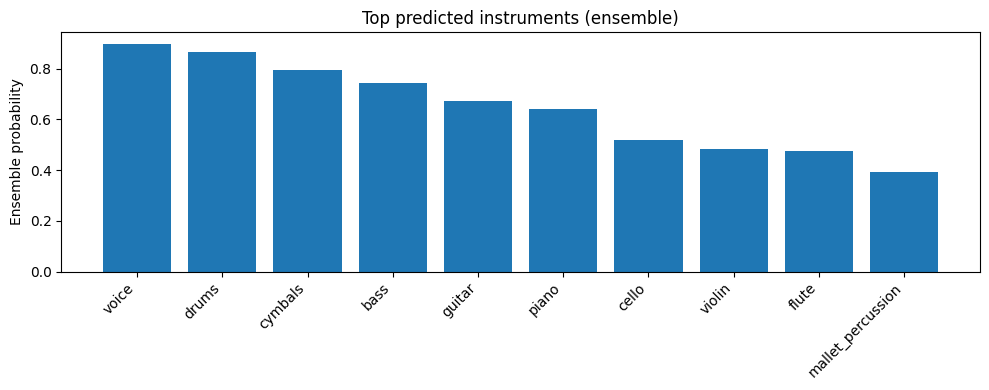

In [ ]:
#  Show results (table + bar plot) =====
df = pd.DataFrame({
    'instrument': class_names,
    'p_bigru': out['p_bigru'],
    'p_xgb': out['p_xgb'],
    'p_ens': out['p_ens'],
    'thr': thr_ens,
    'pred': out['y_hat'],
})

df_sorted = df.sort_values('p_ens', ascending=False).reset_index(drop=True)
display(df_sorted.head(20))

predicted = df[df['pred'] == 1].sort_values('p_ens', ascending=False)
print('\nPredicted instruments (thresholded):')
if len(predicted) == 0:
    print('  (none above threshold)')
else:
    for _, r in predicted.iterrows():
        print(f"  - {r['instrument']}: p_ens={r['p_ens']:.3f}")

# Bar plot: top 10 ensemble probabilities
topk = 10
top = df_sorted.head(topk)
plt.figure(figsize=(10, 4))
plt.bar(top['instrument'], top['p_ens'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Ensemble probability')
plt.title('Top predicted instruments (ensemble)')
plt.tight_layout()
plt.show()


## Notes
- If your prediction looks off, try setting `USE_FIXED_10S=True` (the model was trained on 10s OpenMIC clips).
- For a long song, set `USE_FIXED_10S=False` to scan the whole track with sliding windows.
- The final decision uses your saved per-class thresholds: `thr_ensemble*.npy`.

## Conclusion & future work
- The dataset has **uneven label coverage** and many **unknown labels**, so masking matters.
- BiGRU+Attention and XGBoost provide complementary signals; the ensemble is simple but effective.

Possible improvements (if I had more time):
- stronger augmentation / mixing strategies for audio clips
- calibrating probabilities (temperature scaling) before ensembling
- a small UI wrapper for real‑time demo (streaming / sliding windows)
